# Pipeline for High-z Radio Galaxies 02: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc, brier_score_loss, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
import sklearn.pipeline
from betacal import BetaCalibration
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from joblib import dump, load
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

In [3]:
plt.rcParams['text.usetex'] = True

***

## Reading data

We import our data using the `pandas` package.

In [4]:
save_plot_flag  = False
save_idx_flag   = False
read_idx_flag   = True
save_model_flag = False
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [5]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 
                      'TYPE', 'Z', 'zsp', 'W1mag', 'W2mag', 'spCl', 
                      'num_imputed', 'radio_detect', 'LOFAR_detect'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model 'Sint_LOFAR'

In [6]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)
# file_non_imp_HETDEX
# full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_non_imp_HETDEX, key='df').drop(columns=features_2_discard)

In [7]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [8]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)]

In [9]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies.')

In this dataset, with 118734 elements,
50538 of them are marked as AGN, and 68196 are identified as galaxies.


---

## Possible correlations

In [10]:
print(full_catalog_df.columns.to_list())

['band_num', 'Sint_LOFAR', 'Sint_LOFAR_AB', 'Speak_LOFAR', 'rms_LOFAR', 'Sint_LOFAR_non_imp', 'Sint_LOFAR_AB_non_imp', 'Speak_LOFAR_non_imp', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

Create target

$0$ for galaxies and $1$ for AGN

In [11]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

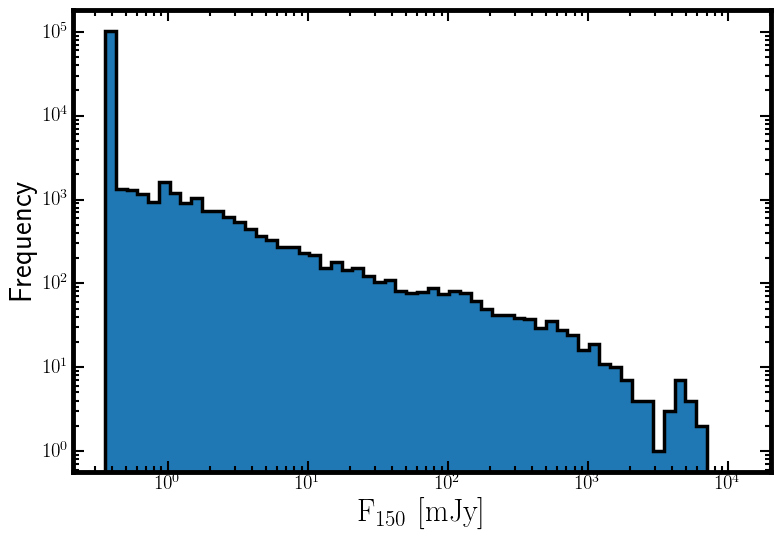

In [12]:
fig    = plt.figure(figsize=(9, 6))
ax1    = fig.add_subplot(111, xscale='log', yscale='log')

min_flx = np.nanmin(full_catalog_df.loc[:, 'Sint_LOFAR'])
max_flx = np.nanmax(full_catalog_df.loc[:, 'Sint_LOFAR'])

bins_flx = np.logspace(np.log10(min_flx), np.log10(max_flx), 60)

ax1.hist(full_catalog_df.loc[:, 'Sint_LOFAR'], bins=bins_flx, ec=(0, 0, 0, 1), lw=2.5, histtype='stepfilled')

ax1.set_xlabel(rf'$\mathrm{{F}}_{{150}}~[\mathrm{{mJy}}]$', fontsize=22)
ax1.set_ylabel('Frequency', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)

# ax1.set_xlim(right=1)

plt.show()

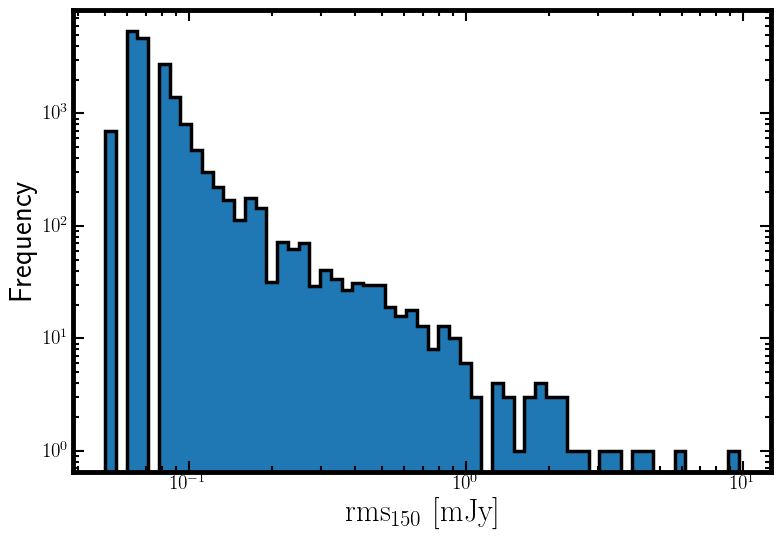

In [13]:
fig    = plt.figure(figsize=(9, 6))
ax1    = fig.add_subplot(111, xscale='log', yscale='log')

min_rms = np.nanmin(full_catalog_df.loc[:, 'rms_LOFAR'])
max_rms = np.nanmax(full_catalog_df.loc[:, 'rms_LOFAR'])

bins_rms = np.logspace(np.log10(min_rms), np.log10(max_rms), 60)

ax1.hist(full_catalog_df.loc[:, 'rms_LOFAR'], bins=bins_rms, ec=(0, 0, 0, 1), lw=2.5, histtype='stepfilled')

ax1.set_xlabel(rf'$\mathrm{{rms}}_{{150}}~[\mathrm{{mJy}}]$', fontsize=22)
ax1.set_ylabel('Frequency', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)

# ax1.set_xlim(right=1)

plt.show()

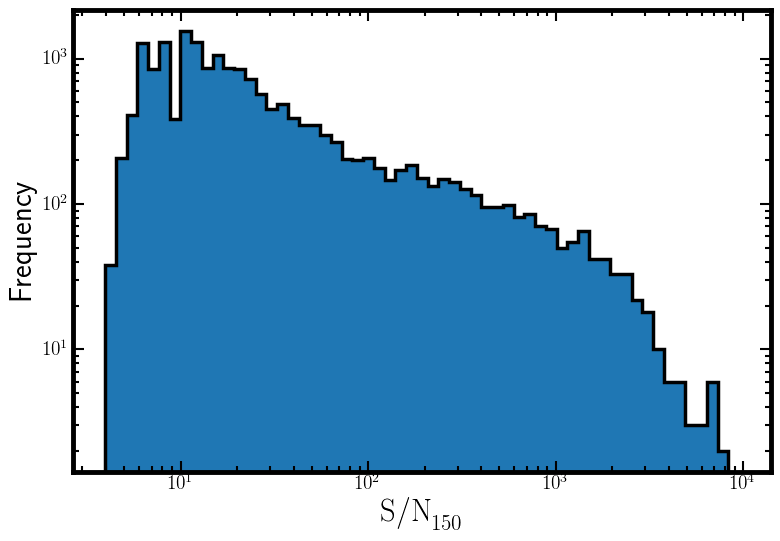

In [14]:
fig    = plt.figure(figsize=(9, 6))
ax1    = fig.add_subplot(111, xscale='log', yscale='log')

snr    = full_catalog_df.loc[:, 'Sint_LOFAR'] / full_catalog_df.loc[:, 'rms_LOFAR']

min_snr = np.nanmin(snr)
max_snr = np.nanmax(snr)

bins_snr = np.logspace(np.log10(min_snr), np.log10(max_snr), 60)

ax1.hist(snr, bins=bins_snr, ec=(0, 0, 0, 1), lw=2.5, histtype='stepfilled')

ax1.set_xlabel(rf'$\mathrm{{S/N}}_{{150}}$', fontsize=22)
ax1.set_ylabel('Frequency', fontsize=22)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=12)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)

# ax1.set_xlim(right=1)

plt.show()

Remove intermediate targets

In [15]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 
                                                'is_gal', 'is_str', 'Sint_LOFAR', 'Sint_LOFAR_non_imp', 
                                                'Speak_LOFAR', 'Speak_LOFAR_non_imp', 'rms_LOFAR', 
                                                'Sint_LOFAR_AB_non_imp', 'Sint_LOFAR_AB'])

## Split data: Test, Train, Validation

In [16]:
target_feat = 'class'

In [17]:
if not read_idx_flag:
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                                   target_feat, use_calibration=use_calibration)
    
    print('Shape of used data in HETDEX')
    print('-' * 60)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 60)
    print()

Save indices of sources in validation sub-set for future steps.

In [18]:
if save_idx_flag:
    known_idx            = full_catalog_df.index.to_numpy()
    train_idx            = train_df.index.to_numpy()
    train_validation_idx = train_test_df.index.to_numpy()  # in the future, fix naming
    validation_idx       = test_df.index.to_numpy()  # in the future, fix naming
    calibration_idx      = calibration_df.index.to_numpy()
    test_idx             = validation_df.index.to_numpy()
    
    np.savetxt(fname=gv.indices_path + 'indices_known.txt',            X=known_idx,            fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_train.txt',            X=train_idx,            fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_train_validation.txt', X=train_validation_idx, fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_validation.txt',       X=validation_idx,       fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_calibration.txt',      X=calibration_idx,      fmt='%i')
    np.savetxt(fname=gv.indices_path + 'indices_test.txt',             X=test_idx,             fmt='%i')

In [19]:
if read_idx_flag:
    known_idx            = np.loadtxt(gv.indices_path + 'indices_known.txt', dtype=int)
    train_idx            = np.loadtxt(gv.indices_path + 'indices_train.txt', dtype=int)
    train_validation_idx = np.loadtxt(gv.indices_path + 'indices_train_validation.txt', dtype=int)  # in the future, fix naming
    validation_idx       = np.loadtxt(gv.indices_path + 'indices_validation.txt', dtype=int)  # in the future, fix naming
    calibration_idx      = np.loadtxt(gv.indices_path + 'indices_calibration.txt', dtype=int)
    test_idx             = np.loadtxt(gv.indices_path + 'indices_test.txt', dtype=int)
    
    train_test_df  = full_catalog_df.loc[train_validation_idx]
    train_df       = full_catalog_df.loc[train_idx]
    test_df        = full_catalog_df.loc[validation_idx]
    calibration_df = full_catalog_df.loc[calibration_idx]
    validation_df  = full_catalog_df.loc[test_idx]
    
    print('Shape of used data in HETDEX')
    print('-' * 60)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 60)
    print()

Shape of used data in HETDEX
------------------------------------------------------------
Full confirmed dataset size:                      (118734, 80)
Data for Modeling (Train, Test, and Calibration): (94987, 80)
Training data:                                    (75989, 80)
Testing data:                                     (9499, 80)
Calibration data:                                 (9499, 80)
Validation data:                                  (23747, 80)
------------------------------------------------------------



---

Do not keep running cells below here!!

## Use Correlation matrix to discard some features

In [20]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [21]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [22]:
rsd_vals

z_y          235.360974
i_z          148.741431
i_y          118.670450
class        116.165096
r_i          101.891040
g_r           98.785978
r_z           86.827674
r_y           84.095283
g_i           78.508836
g_z           74.296327
g_y           73.639736
y_W2          65.652486
H_W3          58.543937
y_W1          54.981624
g_W1          51.845126
r_W1          50.953189
z_W2          50.027130
z_W1          48.441572
i_W1          47.208072
W1_W3         44.669787
J_W3          43.168897
i_W2          43.045768
r_W2          42.304531
g_W2          42.189863
y_J           41.123579
y_H           37.581266
z_J           35.692201
i_J           33.696340
r_J           33.616411
g_J           32.999152
z_H           32.810089
y_K           32.707435
W2_W3         32.698774
y_W3          31.665217
r_H           31.498449
g_H           31.291843
i_H           31.195548
J_H           29.359870
z_K           29.152483
g_K           28.592409
r_K           28.537230
i_K           28

In [23]:
correlation = norm_train_test_df.corr()

In [24]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [25]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [26]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [27]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [28]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'z_H',
 'J_W1',
 'J_W2',
 'g_K',
 'gmag',
 'r_K',
 'rmag',
 'y_K',
 'i_K',
 'z_K',
 'ymag',
 'imag',
 'zmag',
 'W1mproPM',
 'H_W1',
 'W2mproPM',
 'g_W4',
 'J_W3',
 'H_W2',
 'K_W1',
 'Jmag',
 'r_W4',
 'J_W4',
 'K_W2',
 'y_W4',
 'i_W4',
 'z_W4',
 'g_W2',
 'g_W3',
 'W1_W4',
 'r_W3',
 'W2_W4',
 'g_z',
 'y_W3',
 'i_W3',
 'z_W3',
 'i_J',
 'W3mag',
 'J_K',
 'g_y',
 'Kmag',
 'r_W2',
 'i_W1',
 'K_W3',
 'r_W1',
 'g_W1',
 'z_J',
 'Hmag',
 'K_W4',
 'g_i',
 'g_J',
 'W2_W3',
 'r_z',
 'i_W2',
 'H_W4',
 'r_y',
 'z_W1']

In [29]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [30]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [31]:
corr_discard = norm_train_test_discard.corr()

In [32]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
W1_W2     class       0.876719
z_W2      y_W2        0.740491
y_W2      y_W1        0.736353
z_y       i_y         0.735251
band_num  r_J         0.729936
y_J       band_num    0.720519
r_J       y_J         0.716827
y_J       W1_W3       0.710224
          y_W2        0.658470
W1_W2     W1_W3       0.615466
          g_r         0.606648
W3_W4     H_W3        0.595979
W1_W2     r_i         0.592204
g_r       class       0.590457
dtype: float64

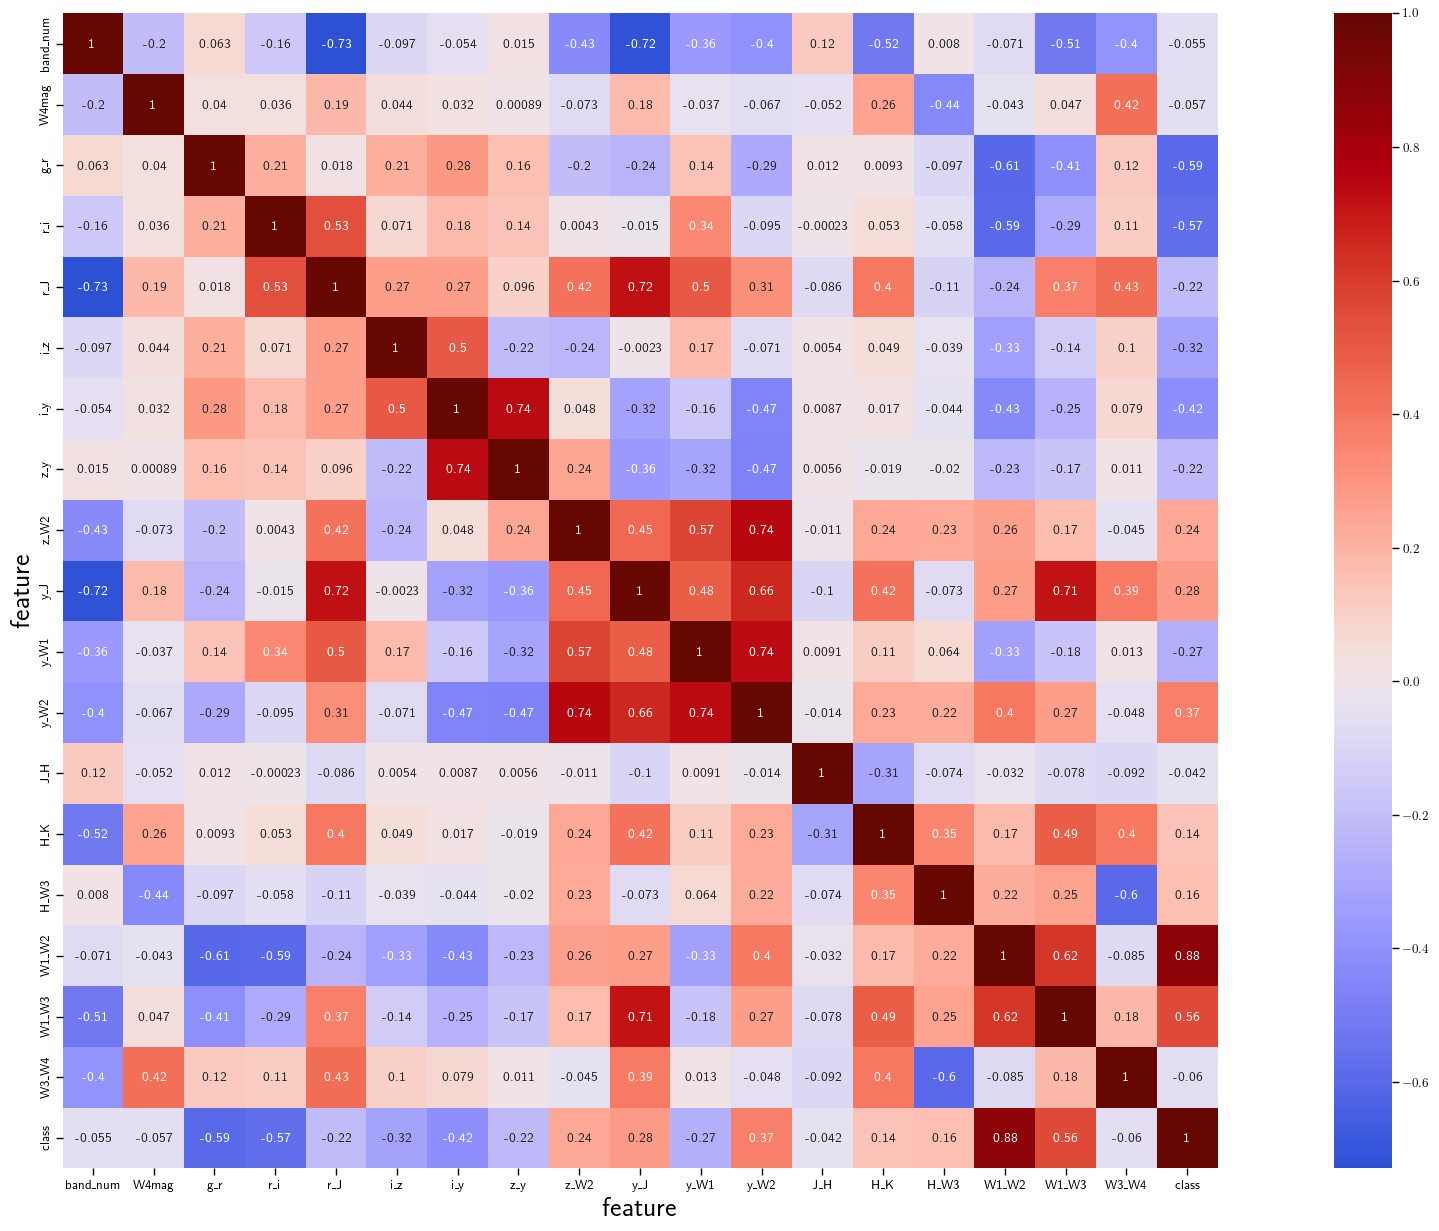

In [33]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')
plt.show()

In [34]:
norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [35]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [36]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y    
H_K       H_K      1.000000
W1_W2     class    0.865511
g_r       class    0.641659
class     W1_W2    0.633942
r_i       class    0.597197
H_W3      W3_W4    0.538692
W1_W3     class    0.449794
band_num  r_J      0.378649
J_H       H_K      0.348683
g_r       W1_W2    0.342422
r_i       W1_W2    0.335536
band_num  y_J      0.327231
i_y       class    0.318677
H_W3      H_K      0.307959
class     r_i      0.294933
          g_r      0.293023
W1_W3     W1_W2    0.260693
i_z       class    0.255062
band_num  H_K      0.229297
W1_W2     W1_W3    0.224904
dtype: float64

In [37]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [38]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [39]:
list_drop_pps = []

In [40]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [41]:
list_drop_pps

[]

In [42]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [43]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=gv.seed)

In [44]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,W1_W2,class,0.865511,classification,True,weighted F1,0.5124,0.934423,DecisionTreeClassifier()
1,g_r,class,0.641659,classification,True,weighted F1,0.5124,0.825273,DecisionTreeClassifier()
2,r_i,class,0.597197,classification,True,weighted F1,0.5124,0.803593,DecisionTreeClassifier()
3,W1_W3,class,0.449794,classification,True,weighted F1,0.5124,0.731719,DecisionTreeClassifier()
4,i_y,class,0.318677,classification,True,weighted F1,0.5124,0.667787,DecisionTreeClassifier()
5,i_z,class,0.255062,classification,True,weighted F1,0.5124,0.636768,DecisionTreeClassifier()
6,y_W2,class,0.221932,classification,True,weighted F1,0.5124,0.620614,DecisionTreeClassifier()
7,band_num,class,0.217672,classification,True,weighted F1,0.5124,0.618537,DecisionTreeClassifier()
8,y_W1,class,0.214398,classification,True,weighted F1,0.5124,0.616940,DecisionTreeClassifier()
9,y_J,class,0.158134,classification,True,weighted F1,0.5124,0.589506,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [45]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = pps_pred_target.x.to_list()  # After Boruta

In [46]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [47]:
exp_AGN = pyc.setup(data                     = train_df,
                    test_data                = test_df,
                    target                   = target_feat,
                    session_id               = gv.seed,
                    silent                   = True,
                    feature_selection        = False,
                    feature_selection_method = 'boruta',
                    data_split_stratify      = True,
                    numeric_features         = final_feats,
                    ignore_features          = feats_2_discard,
                    transformation           = True,
                    transformation_method    = 'yeo-johnson',
                    n_jobs                   = 12,
                    normalize                = True,
                    normalize_method         = 'zscore',
                    use_gpu                  = False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(75989, 80)"
5,Missing Values,False
6,Numeric Features,18
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


Add F_beta score ($\beta = 1.1$).

In [48]:
pyc.add_metric('f_beta', 'F beta', gf.f_beta, greater_is_better=True)

Name                                        F beta score
Display Name                                F beta score
Score Function       <function f_beta at 0x7f6b0bd2ad30>
Scorer                               make_scorer(f_beta)
Target                                              pred
Args                                                  {}
Greater is Better                                   True
Multiclass                                          True
Custom                                              True
Name: f_beta, dtype: object

In [49]:
pyc.add_metric('brier_skill', 'Brier skill', gf.brier_skill_score, greater_is_better=True)

Name                                              Brier skill score
Display Name                                      Brier skill score
Score Function       <function brier_skill_score at 0x7f6b0bd2adc0>
Scorer                               make_scorer(brier_skill_score)
Target                                                         pred
Args                                                             {}
Greater is Better                                              True
Multiclass                                                     True
Custom                                                         True
Name: brier_skill, dtype: object

In [50]:
pyc.add_metric('brier_score', 'Brier score', brier_score_loss, greater_is_better=False)

Name                                                       Brier score
Display Name                                               Brier score
Score Function           <function brier_score_loss at 0x7f6b23aff310>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: brier_score, dtype: object

In [51]:
pyc.add_metric('logloss', 'Log Loss', log_loss, greater_is_better=False)

Name                                                       Log Loss
Display Name                                               Log Loss
Score Function                <function log_loss at 0x7f6b23aff0d0>
Scorer               make_scorer(log_loss, greater_is_better=False)
Target                                                         pred
Args                                                             {}
Greater is Better                                             False
Multiclass                                                     True
Custom                                                         True
Name: logloss, dtype: object

In [52]:
pyc.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'r_i', 'r_J', 'i_z', 'i_y', 'z_y', 'z_W2',
       'y_J', 'y_W1', 'y_W2', 'J_H', 'H_K', 'H_W3', 'W1_W2', 'W1_W3', 'W3_W4'],
      dtype='object')

In [53]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [54]:
dummy_strat = DummyClassifier(strategy='stratified', random_state=gv.seed)

In [55]:
ctbst =pyc.create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9613,0.9912,0.9558,0.9534,0.9546,0.9209,0.9209,0.9547,0.9091,0.0387,1.3363
1,0.9685,0.9927,0.9647,0.9615,0.9631,0.9357,0.9357,0.9633,0.9261,0.0315,1.0863
2,0.9609,0.9917,0.9530,0.9551,0.9540,0.9200,0.9200,0.9539,0.9082,0.0391,1.3499
3,0.9650,0.9924,0.9595,0.9583,0.9589,0.9284,0.9284,0.9590,0.9177,0.0350,1.2090
4,0.9605,0.9899,0.9564,0.9511,0.9537,0.9193,0.9193,0.9540,0.9072,0.0395,1.3636
5,0.9614,0.9907,0.9558,0.9537,0.9548,0.9212,0.9212,0.9549,0.9094,0.0386,1.3318
6,0.9630,0.9911,0.9598,0.9536,0.9567,0.9244,0.9245,0.9570,0.9131,0.0370,1.2772
7,0.9646,0.9921,0.9645,0.9530,0.9587,0.9277,0.9278,0.9592,0.9168,0.0354,1.2227
8,0.9622,0.9917,0.9620,0.9499,0.9559,0.9229,0.9229,0.9565,0.9113,0.0378,1.3045


In [56]:
xgbst = pyc.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9624,0.9900,0.9567,0.9549,0.9558,0.9230,0.9230,0.9559,0.9116,0.0376,1.2999
1,0.9685,0.9925,0.9635,0.9626,0.9631,0.9357,0.9357,0.9631,0.9261,0.0315,1.0863
2,0.9620,0.9911,0.9558,0.9549,0.9553,0.9222,0.9222,0.9554,0.9106,0.0380,1.3136
3,0.9642,0.9912,0.9583,0.9577,0.9580,0.9268,0.9268,0.9580,0.9159,0.0358,1.2363
4,0.9599,0.9895,0.9558,0.9502,0.9530,0.9180,0.9180,0.9532,0.9057,0.0401,1.3863
5,0.9596,0.9901,0.9533,0.9519,0.9526,0.9174,0.9174,0.9527,0.9051,0.0404,1.3954
6,0.9628,0.9903,0.9595,0.9533,0.9564,0.9239,0.9239,0.9567,0.9125,0.0372,1.2863
7,0.9635,0.9912,0.9598,0.9548,0.9573,0.9255,0.9255,0.9575,0.9144,0.0365,1.2590
8,0.9622,0.9914,0.9645,0.9478,0.9560,0.9229,0.9230,0.9568,0.9113,0.0378,1.3045


In [57]:
et = pyc.create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9546,0.9884,0.9453,0.9479,0.9466,0.9071,0.9071,0.9465,0.8933,0.0454,1.5681
1,0.9672,0.9923,0.9629,0.9602,0.9616,0.9330,0.9330,0.9617,0.9230,0.0328,1.1318
2,0.9584,0.9891,0.9542,0.9484,0.9513,0.9150,0.9150,0.9516,0.9023,0.0416,1.4363
3,0.9643,0.9904,0.9583,0.9580,0.9581,0.9271,0.9271,0.9581,0.9162,0.0357,1.2318
4,0.9585,0.9866,0.9549,0.9481,0.9515,0.9153,0.9153,0.9518,0.9026,0.0415,1.4317
5,0.9585,0.9882,0.9533,0.9495,0.9514,0.9153,0.9153,0.9516,0.9026,0.0415,1.4317
6,0.9592,0.9885,0.9561,0.9485,0.9523,0.9167,0.9167,0.9526,0.9042,0.0408,1.4090
7,0.9624,0.9903,0.9595,0.9524,0.9560,0.9231,0.9231,0.9563,0.9116,0.0376,1.2999
8,0.9610,0.9890,0.9617,0.9476,0.9546,0.9205,0.9206,0.9553,0.9085,0.0390,1.3454


In [58]:
rf = pyc.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9563,0.9892,0.9481,0.9492,0.9486,0.9106,0.9106,0.9486,0.8973,0.0437,1.5090
1,0.9684,0.9923,0.9620,0.9638,0.9629,0.9354,0.9354,0.9628,0.9258,0.0316,1.0909
2,0.9591,0.9898,0.9536,0.9504,0.9520,0.9163,0.9163,0.9522,0.9038,0.0409,1.4136
3,0.9647,0.9909,0.9576,0.9594,0.9585,0.9278,0.9279,0.9584,0.9171,0.0353,1.2181
4,0.9607,0.9880,0.9586,0.9495,0.9540,0.9196,0.9197,0.9544,0.9075,0.0393,1.3590
5,0.9610,0.9876,0.9564,0.9523,0.9543,0.9204,0.9204,0.9545,0.9085,0.0390,1.3454
6,0.9600,0.9895,0.9552,0.9511,0.9531,0.9182,0.9182,0.9533,0.9060,0.0400,1.3817
7,0.9628,0.9914,0.9614,0.9517,0.9565,0.9239,0.9240,0.9569,0.9125,0.0372,1.2863
8,0.9618,0.9900,0.9614,0.9496,0.9555,0.9221,0.9221,0.9560,0.9104,0.0382,1.3181


In [59]:
gbc = pyc.create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9567,0.9897,0.9533,0.9454,0.9493,0.9115,0.9116,0.9497,0.8983,0.0433,1.4954
1,0.9657,0.9920,0.9651,0.9547,0.9599,0.9298,0.9299,0.9604,0.9193,0.0343,1.1863
2,0.9570,0.9906,0.9536,0.9457,0.9497,0.9121,0.9121,0.9500,0.8989,0.0430,1.4863
3,0.9618,0.9909,0.9545,0.9557,0.9551,0.9219,0.9219,0.9551,0.9103,0.0382,1.3181
4,0.9582,0.9886,0.9564,0.9459,0.9511,0.9145,0.9146,0.9516,0.9017,0.0418,1.4454
5,0.9580,0.9896,0.9546,0.9472,0.9509,0.9142,0.9143,0.9512,0.9014,0.0420,1.4499
6,0.9583,0.9895,0.9539,0.9484,0.9511,0.9147,0.9148,0.9514,0.9020,0.0417,1.4408
7,0.9608,0.9906,0.9586,0.9498,0.9542,0.9199,0.9199,0.9546,0.9079,0.0392,1.3545
8,0.9572,0.9902,0.9589,0.9417,0.9502,0.9127,0.9129,0.9510,0.8995,0.0428,1.4772


In [60]:
dummy_strt = pyc.create_model(dummy_strat)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.4998,0.4877,0.4063,0.4113,0.4088,-0.0247,-0.0247,0.4085,-0.1753,0.5002,17.2764
1,0.5148,0.5030,0.4239,0.4291,0.4265,0.0061,0.0061,0.4263,-0.1401,0.4852,16.7582
2,0.5219,0.5103,0.4323,0.4376,0.4349,0.0206,0.0206,0.4347,-0.1234,0.4781,16.5128
3,0.5077,0.4958,0.4156,0.4207,0.4181,-0.0085,-0.0085,0.4179,-0.1568,0.4923,17.0037
4,0.5227,0.5111,0.4332,0.4385,0.4358,0.0222,0.0222,0.4356,-0.1215,0.4773,16.4855
5,0.4994,0.4873,0.4059,0.4110,0.4084,-0.0254,-0.0254,0.4082,-0.1759,0.5006,17.2900
6,0.5068,0.4948,0.4145,0.4197,0.4171,-0.0103,-0.0103,0.4169,-0.1586,0.4932,17.0355
7,0.5173,0.5056,0.4269,0.4322,0.4295,0.0112,0.0112,0.4293,-0.1338,0.4827,16.6719
8,0.5076,0.4957,0.4155,0.4207,0.4180,-0.0087,-0.0087,0.4178,-0.1567,0.4924,17.0082


In [61]:
metric_to_optimize    = 'Recall'

In [62]:
# final_selection_clf   = ['catboost', 'xgboost', 'et', 'rf', 'gbc', dummy_strat]  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
final_selection_clf   = [ctbst, xgbst, et, rf, gbc, dummy_strt]  # knn, qda, nb lack feat importances neither coefs, ridge lacks scores
initial_selection_clf = ['rf', 'gbc', 'et', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort=metric_to_optimize)  # 1:15 hour for used_models_clf
# top_model_AGN = pyc.compare_models(n_select=n_models, include=initial_selection_clf, sort=metric_to_optimize)  # 10 minutes, using all models.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss,TT (Sec)
0,CatBoost Classifier,0.9631,0.9915,0.9591,0.9545,0.9568,0.9246,0.9246,0.9570,0.9134,0.0369,1.2736,2.4610
1,Extreme Gradient Boosting,0.9628,0.9907,0.9588,0.9541,0.9564,0.9240,0.9240,0.9567,0.9127,0.0372,1.2840,9.7590
3,Random Forest Classifier,0.9616,0.9897,0.9571,0.9528,0.9549,0.9214,0.9214,0.9552,0.9097,0.0384,1.3277,1.5410
2,Extra Trees Classifier,0.9606,0.9891,0.9563,0.9513,0.9538,0.9194,0.9194,0.9540,0.9073,0.0394,1.3622,0.4340
4,Gradient Boosting Classifier,0.9592,0.9901,0.9563,0.9482,0.9522,0.9166,0.9166,0.9526,0.9041,0.0408,1.4104,3.2730
5,Dummy Classifier,0.5116,0.4998,0.4202,0.4254,0.4228,-0.0004,-0.0004,0.4225,-0.1474,0.4884,16.8680,0.2980


Thus, we select `catboost` as meta learner.

Then, we stack the models.

In [63]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0], 
                                     optimize=metric_to_optimize, restack=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9617,0.9912,0.9573,0.9529,0.9551,0.9217,0.9217,0.9553,0.9100,0.0383,1.3227
1,0.9691,0.9928,0.9654,0.9621,0.9637,0.9368,0.9368,0.9639,0.9273,0.0309,1.0681
2,0.9608,0.9917,0.9536,0.9542,0.9539,0.9198,0.9198,0.9539,0.9079,0.0392,1.3545
3,0.9637,0.9923,0.9576,0.9570,0.9573,0.9257,0.9257,0.9574,0.9147,0.0363,1.2545
4,0.9607,0.9898,0.9570,0.9508,0.9539,0.9196,0.9196,0.9542,0.9075,0.0393,1.3590
5,0.9608,0.9906,0.9552,0.9528,0.9540,0.9198,0.9198,0.9541,0.9079,0.0392,1.3545
6,0.9624,0.9911,0.9601,0.9519,0.9560,0.9231,0.9231,0.9564,0.9116,0.0376,1.2999
7,0.9658,0.9922,0.9638,0.9561,0.9600,0.9301,0.9301,0.9603,0.9196,0.0342,1.1818
8,0.9622,0.9917,0.9586,0.9530,0.9558,0.9228,0.9228,0.9560,0.9113,0.0378,1.3045


In [64]:
catboost_tune_grid          = pyc.models(internal=True).loc['catboost']['Tune Grid']
catboost_tune_grid['depth'] = [3, 4, 5, 6, 7, 8, 9, 10]  # old = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [65]:
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, 
                               early_stopping   = True, 
                               optimize         = metric_to_optimize, 
                               search_library   = 'tune-sklearn', 
                               search_algorithm = 'bayesian', 
                               choose_better    = True, 
                               custom_grid      = catboost_tune_grid)  # 1h15

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
Fold,,,,,,,,,,,
0,0.9625,0.9906,0.9579,0.9541,0.9560,0.9233,0.9233,0.9562,0.9119,0.0375,1.2954
1,0.9688,0.9932,0.9654,0.9615,0.9634,0.9362,0.9362,0.9636,0.9267,0.0312,1.0772
2,0.9614,0.9910,0.9549,0.9546,0.9547,0.9211,0.9211,0.9547,0.9094,0.0386,1.3318
3,0.9646,0.9916,0.9598,0.9571,0.9585,0.9276,0.9276,0.9586,0.9168,0.0354,1.2227
4,0.9600,0.9897,0.9570,0.9494,0.9532,0.9183,0.9183,0.9536,0.9060,0.0400,1.3818
5,0.9608,0.9904,0.9577,0.9506,0.9541,0.9199,0.9199,0.9544,0.9079,0.0392,1.3545
6,0.9633,0.9904,0.9623,0.9520,0.9571,0.9250,0.9251,0.9576,0.9138,0.0367,1.2681
7,0.9637,0.9916,0.9635,0.9518,0.9576,0.9258,0.9259,0.9582,0.9147,0.0363,1.2545
8,0.9621,0.9915,0.9648,0.9472,0.9559,0.9227,0.9228,0.9567,0.9110,0.0379,1.3090


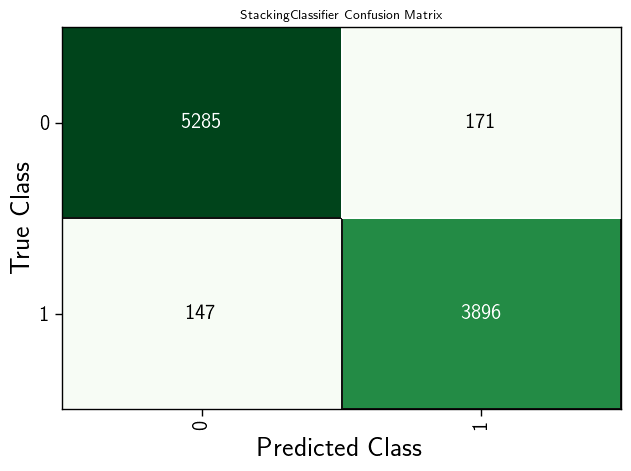

In [53]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

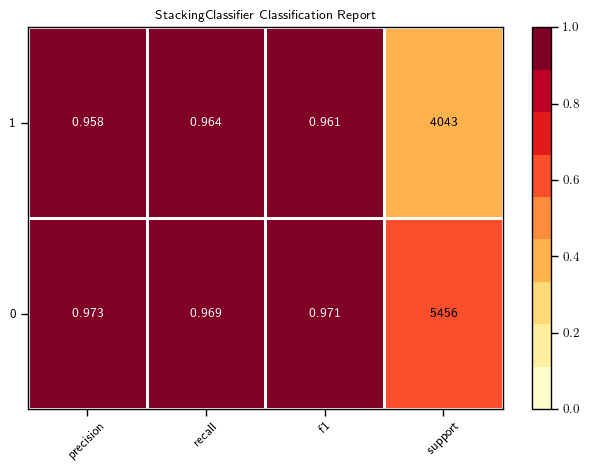

In [54]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

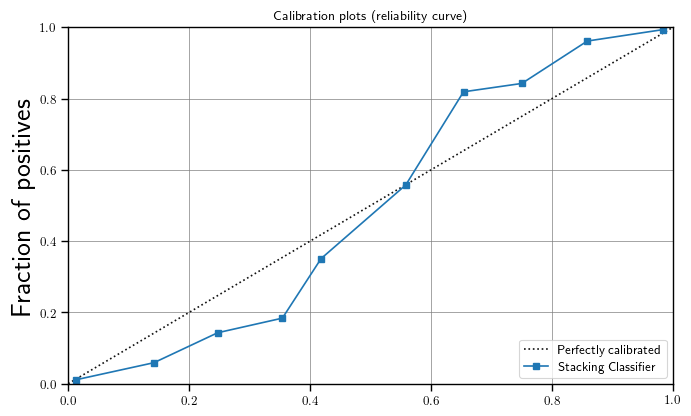

In [55]:
pyc.plot_model(tuned_AGN_clf, plot='calibration')

In [55]:
# pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='feature_all')

In [66]:
pyc.plot_model(tuned_AGN_clf.final_estimator_, plot='parameter')

,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,110
sampling_frequency,PerTree
leaf_estimation_method,Newton
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant
feature_border_type,GreedyLogSum


In [67]:
pyc.plot_model(tuned_AGN_clf.final_estimator, plot='parameter')

,Parameters
depth,6
l2_leaf_reg,10
border_count,254
thread_count,12
verbose,False
random_strength,0.1
task_type,CPU
n_estimators,110
random_state,42
eta,1e-06


In [68]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['text.usetex'] = True

In [69]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
0,Stacking Classifier,0.9665227919,0.9928153445,0.9636408607,0.9579542660,0.9607891492,0.9315831297,0.9315955489,0.9610594511,0.9213455319,0.0334772081,1.1562762001


,Score_0,Score_1
count,9499.000000,9499.000000
mean,0.500020,0.499980
std,0.000112,0.000112
min,0.499877,0.499876
25%,0.499881,0.499877
50%,0.500109,0.499891
75%,0.500123,0.500119
max,0.500124,0.500123


In [70]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
0,Stacking Classifier,0.9665227919,0.9928153445,0.9636408607,0.9579542660,0.9607891492,0.9315831297,0.9315955489,0.9610594511,0.9213455319,0.0334772081,1.1562762001


In [71]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.miniforge3/envs/clone_test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/clone_test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/clone_test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/clone_test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: F

In [72]:
pyc.predict_model(final_AGN_clf, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10).loc[:, ['Score_0', 'Score_1']].describe()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F beta score,Brier skill score,Brier score,Log Loss
0,Stacking Classifier,0.9665227919,0.9928153445,0.9636408607,0.9579542660,0.9607891492,0.9315831297,0.9315955489,0.9610594511,0.9213455319,0.0334772081,1.1562762001


,Score_0,Score_1
count,9499.000000,9499.000000
mean,0.500020,0.499980
std,0.000112,0.000112
min,0.499877,0.499876
25%,0.499881,0.499877
50%,0.500109,0.499891
75%,0.500123,0.500119
max,0.500124,0.500123


In [65]:
if save_model_flag:
    pyc.save_model(final_AGN_clf, gv.models_path + gv.AGN_gal_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [48]:
if load_model_flag:
    final_AGN_clf = pyc.load_model(gv.models_path + gv.AGN_gal_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [49]:
base_models_names = gf.get_base_estimators_names(final_AGN_clf)
base_models       = gf.get_base_estimators_models(final_AGN_clf)

In [50]:
print('Running data pre-processing:\n')
extended_data_AGN_df = gf.preprocess_data(final_AGN_clf, validation_df, base_models_names)

Running data pre-processing:



In [51]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_AGN_clf, extended_data_AGN_df)

In [52]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_AGN_df)

In [53]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [54]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for xgboost...
Calculating for rf...
Calculating for et...
Calculating for gbc...


xgboost                   rf                   et                  gbc  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W1_W2    77.0670     W1_W2    35.1296     W1_W2    38.6199     W1_W2   
1        H_K     2.7405       g_r    16.0973     W1_W3    12.5938       g_r   
2      W1_W3     2.2839       r_i    16.0661       r_i     7.6307       r_J   
3      W4mag     2.0574     W1_W3     6.2427       g_r     6.1386     W1_W3   
4        g_r     1.9624       i_z     5.3204      y_W2     5.0826       r_i   
5        r_J     1.8633       i_y     3.9957       r_J     4.8239     W3_W4   
6   band_num     1.7867      y_W2     3.5082      y_W1     4.5595       H_K   
7      W3_W4     1.4152       r_J     3.2475       y_J     3.8160     W4mag   
8        r_i     1.1841      y_W1     2.1583       i_y     3.6014      H_W3   
9       H_W3     1.0431      z_W2     1.9179  band_num     3.3393       i_z   
10       i_z     1.0385  band_num     1.4707      z_W2     2.8597      y_W2   
11      z_W2     0.9984       z_y     1.3360       i_z     2.6221  band_num   
12       y_J     0.8915       y_J     1.1797       z_y     1.4261      z_W2   
13      y_W2     0.8777      H_W3     0.6893     W3_W4     0.8644       i_y   
14       i_y     0.7876       H_K     0.6676      H_W3     0.6556      y_W1   
15       J_H     0.6855     W3_W4     0.5453     W4mag     0.6467       J_H   
16       z_y     0.6599       J_H     0.2228       H_K     0.4411       y_J   
17      y_W1     0.6571     W4mag     0.2048       J_H     0.2786       z_y   

               
   Importance  
0     94.2216  
1      1.9150  
2      1.1073  
3      0.9743  
4      0.5804  
5      0.2478  
6      0.1774  
7      0.1698  
8      0.1446  
9      0.1419  
10     0.0872  
11     0.0848  
12     0.0523  
13     0.0353  
14     0.0237  
15     0.0157  
16     0.0148  
17     0.0061

In [55]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
coef_sorted_meta_df_copy_sum['Cumulative_sum'] = coef_sorted_meta_df_copy_sum.loc[:, 'Importance'].cumsum()
print('Meta model')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance,Cumulative_sum
0,gbc,49.7094,49.7094
1,et,19.4027,69.1121
2,xgboost,14.0457,83.1579
3,rf,8.9807,92.1385
4,r_J,1.9659,94.1045
5,H_K,1.0965,95.2010
6,W1_W3,0.9436,96.1445
7,band_num,0.7688,96.9134
8,W1_W2,0.6350,97.5483
9,y_W1,0.4766,98.0249


In [56]:
print('Combined feature importances scaled to sum 100')
coef_sorted_comb_sum = coef_sorted_meta_df_copy_sum.copy().set_index('Feature')
for key in coef_sorted_base_df_copy_sum.keys():
    factor = coef_sorted_meta_df_copy_sum.set_index('Feature').loc[key] / 100
    tmp_feat_imp = coef_sorted_base_full_df.loc[:, key].copy().set_index('Feature')
    coef_sorted_comb_sum = coef_sorted_comb_sum + tmp_feat_imp * factor
    coef_sorted_comb_sum = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=False)# .drop(index=base_models_names)
    coef_sorted_comb_sum['Cumulative_sum'] = coef_sorted_comb_sum.loc[:, 'Importance'].cumsum()
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(coef_sorted_comb_sum.drop(index=base_models_names))

Combined feature importances scaled to sum 100


,Cumulative_sum,Importance
Feature,,
W1_W2,68.9448,68.9448
W1_W3,73.6976,4.7528
g_r,77.7379,4.0402
r_J,81.7436,4.0057
r_i,85.5234,3.7798
band_num,87.3653,1.8419
H_K,89.0805,1.7152
y_W1,90.7396,1.6591
y_W2,92.2528,1.5131


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W2	68.945
W1_W3	4.753
g_r	4.040
r_J	4.006
r_i	3.780
band_num	1.842
H_K	1.715
y_W1	1.659
y_W2	1.513
i_y	1.441
i_z	1.366
y_J	1.187
z_W2	1.026
z_y	0.722
W3_W4	0.669
W4mag	0.558
H_W3	0.408
J_H	0.371


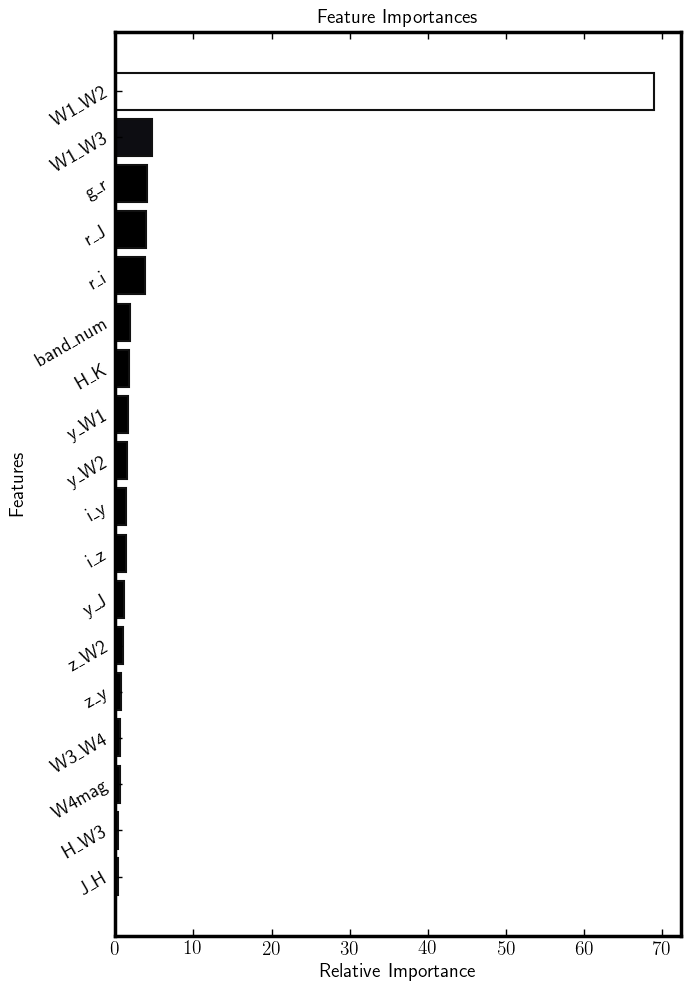

In [57]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    features_df = coef_sorted_comb_sum.sort_values(by=['Importance'], ascending=True).drop(index=base_models_names)
    features    = features_df.index.to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), importances,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_classification_AGN_galaxy_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(importances)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [58]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_AGN_clf, 'catboost', 'classification')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,catboost,xgboost,rf,et,gbc
learning_rate,0.0000,0.3000,NaN,NaN,0.1000
depth,6.0000,NaN,NaN,NaN,NaN
random_strength,0.1000,NaN,NaN,NaN,NaN
l2_leaf_reg,10.0000,NaN,NaN,NaN,NaN
n_estimators,NaN,100,100,100,100
subsample,NaN,1.0000,NaN,NaN,1.0000
max_depth,NaN,6.0000,NaN,NaN,3.0000
colsample_bytree,NaN,1.0000,NaN,NaN,NaN
min_child_weight,NaN,1.0000,NaN,NaN,NaN
reg_alpha,NaN,0.0000,NaN,NaN,NaN


---

In [59]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 75,989
Size of test set is  9,499


#### Calculate optimal threshold for classification

In [60]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,       probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,        probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df,  probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_AGN_clf, data=calibration_df, probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df,  probability_threshold=gv.naive_AGN_thresh, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9837476477,0.9994837732,0.9813257482,0.9805072441,0.9809163254,0.9667637106,0.9667639658


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9665227919,0.9928153445,0.9636408607,0.9579542660,0.9607891492,0.9315831297,0.9315955489


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9801130681,0.9980954093,0.9776898343,0.9756386524,0.9766631663,0.9593375340,0.9593391398


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9646278556,0.9912102795,0.9626514964,0.9546234977,0.9586206897,0.9277336045,0.9277584109


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9599528361,0.9900743319,0.9588444796,0.9476874939,0.9532333415,0.9182194217,0.9182675038


#### Random selection (dummy) metrics

In [61]:
cm_mat_train_random      = gf.conf_mat_random(train_prediction_clf[target_feat])
cm_mat_test_random       = gf.conf_mat_random(test_prediction_clf[target_feat])
cm_mat_train_test_random = gf.conf_mat_random(train_test_prediction_clf[target_feat])
cm_mat_calib_random      = gf.conf_mat_random(calib_prediction_clf[target_feat])
cm_mat_val_random        = gf.conf_mat_random(validation_prediction_clf[target_feat])

In [62]:
random_scores_df = gf.create_scores_df([cm_mat_train_random, cm_mat_test_random, cm_mat_train_test_random, 
                                        cm_mat_calib_random, cm_mat_val_random],
                                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],
                                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [63]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(random_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.4256,0.0000,0.4256,0.4256
Test,0.4256,0.0000,0.4256,0.4256
Train+Test,0.4256,0.0000,0.4256,0.4256
Calibration,0.4256,0.0000,0.4256,0.4256
Validation,0.4257,0.0000,0.4257,0.4257


#### Naive threshold metrics.

In [64]:
cm_mat_train_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [65]:
naive_scores_df = gf.create_scores_df([cm_mat_train_naive, cm_mat_test_naive, cm_mat_train_test_naive, cm_mat_calib_naive, cm_mat_val_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [66]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(naive_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9810,0.9668,0.9805,0.9813
Test,0.9611,0.9316,0.9580,0.9636
Train+Test,0.9768,0.9593,0.9756,0.9777
Calibration,0.9590,0.9278,0.9546,0.9627
Validation,0.9538,0.9183,0.9477,0.9588


#### Calibration curve

In [67]:
fract_positiv_train_test, mean_pred_val_train_test =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib, mean_pred_val_calib =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val, mean_pred_val_val =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Score_1'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

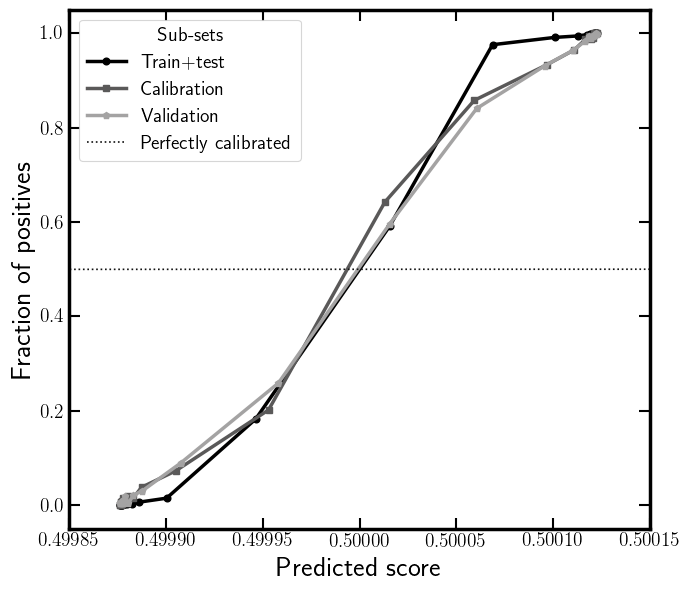

In [70]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test, fract_positiv_train_test, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib, fract_positiv_calib, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val, fract_positiv_val, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
ax1.set_xlim(left=0.49985, right=0.50015)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_pre_calib_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

#### Calculate optimal threshold for prediction

Calculate ROC AUC values and plots.

In [71]:
roc_auc_train      = roc_auc_score(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
roc_auc_test       = roc_auc_score(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
roc_auc_train_test = roc_auc_score(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
roc_auc_calib      = roc_auc_score(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
roc_auc_validation = roc_auc_score(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

In [72]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for train+test = {roc_auc_train_test:.5f}')
print(f'Area under the curve (ROC) for calibraton = {roc_auc_calib:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.99948
Area under the curve (ROC) for test       = 0.99282
Area under the curve (ROC) for train+test = 0.99810
Area under the curve (ROC) for calibraton = 0.99121
Area under the curve (ROC) for validation = 0.99007


In [73]:
fpr_train,      tpr_train,      thresh_train      = roc_curve(train_prediction_clf.loc[:, target_feat],      train_prediction_clf.loc[:, 'Score_1'])
fpr_test,       tpr_test,       thresh_test       = roc_curve(test_prediction_clf.loc[:, target_feat],       test_prediction_clf.loc[:, 'Score_1'])
fpr_train_test, tpr_train_test, thresh_train_test = roc_curve(train_test_prediction_clf.loc[:, target_feat], train_test_prediction_clf.loc[:, 'Score_1'])
fpr_calib,      tpr_calib,      thresh_calib      = roc_curve(calib_prediction_clf.loc[:, target_feat],      calib_prediction_clf.loc[:, 'Score_1'])
fpr_val,        tpr_val,        thresh_val        = roc_curve(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Score_1'])

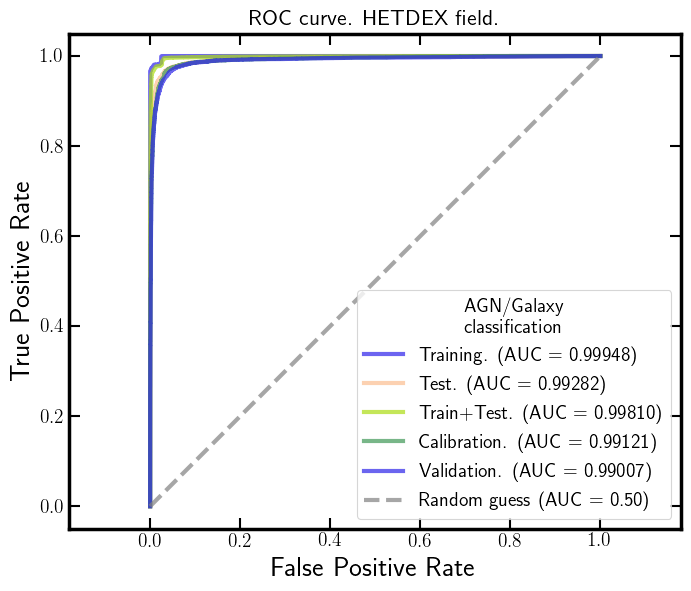

In [74]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = RocCurveDisplay(fpr=fpr_train,      tpr=tpr_train,      roc_auc=roc_auc_train)
viz_test        = RocCurveDisplay(fpr=fpr_test,       tpr=tpr_test,       roc_auc=roc_auc_test)
viz_train_test  = RocCurveDisplay(fpr=fpr_train_test, tpr=tpr_train_test, roc_auc=roc_auc_train_test)
viz_calib       = RocCurveDisplay(fpr=fpr_calib,      tpr=tpr_calib,      roc_auc=roc_auc_calib)
viz_val         = RocCurveDisplay(fpr=fpr_val,        tpr=tpr_val,        roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.7, label=f"Training.    (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,        lw=3, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.7, label=f"Test.        (AUC = {roc_auc_test:0.5f})")
viz_train_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.7, label=f"Train+Test.  (AUC = {roc_auc_train_test:0.5f})")
viz_calib.plot(ax=ax1,       lw=3, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.7, label=f"Calibration. (AUC = {roc_auc_calib:0.5f})")
viz_val.plot(ax=ax1,         lw=3, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.7, label=f"Validation.  (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'AUC_ROC_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

##### Find optimal threshold for each sub-set

In [75]:
opt_t_train      = thresh_train[np.argmax(tpr_train - fpr_train)]
opt_t_test       = thresh_test[np.argmax(tpr_test - fpr_test)]
opt_t_train_test = thresh_train_test[np.argmax(tpr_train_test - fpr_train_test)]
opt_t_calib      = thresh_calib[np.argmax(tpr_calib - fpr_calib)]
opt_t_validation = thresh_val[np.argmax(tpr_val - fpr_val)]

In [76]:
print(f'Optimal threshold from area under the curve (ROC) for training    = {opt_t_train:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for test        = {opt_t_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for train+test  = {opt_t_train_test:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for calibration = {opt_t_calib:.5f}')
print(f'Optimal threshold from area under the curve (ROC) for validation  = {opt_t_validation:.5f}')

Optimal threshold from area under the curve (ROC) for training    = 0.49997
Optimal threshold from area under the curve (ROC) for test        = 0.49998
Optimal threshold from area under the curve (ROC) for train+test  = 0.49997
Optimal threshold from area under the curve (ROC) for calibration = 0.49998
Optimal threshold from area under the curve (ROC) for validation  = 0.49998


##### Precision-Recall curve

In [77]:
prec_train,      recall_train,      thresh_train      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Score_1'],      pos_label=1)
prec_test,       recall_test,       thresh_test       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Score_1'],       pos_label=1)
prec_train_test, recall_train_test, thresh_train_test = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_calib,      recall_calib,      thresh_calib      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Score_1'], pos_label=1)
prec_validation, recall_validation, thresh_validation = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Score_1'], pos_label=1)

AUC for PR curve

In [78]:
auc_pr_train      = auc(recall_train,      prec_train)
auc_pr_test       = auc(recall_test,       prec_test)
auc_pr_train_test = auc(recall_train_test, prec_train_test)
auc_pr_calib      = auc(recall_calib,      prec_calib)
auc_pr_validation = auc(recall_validation, prec_validation)

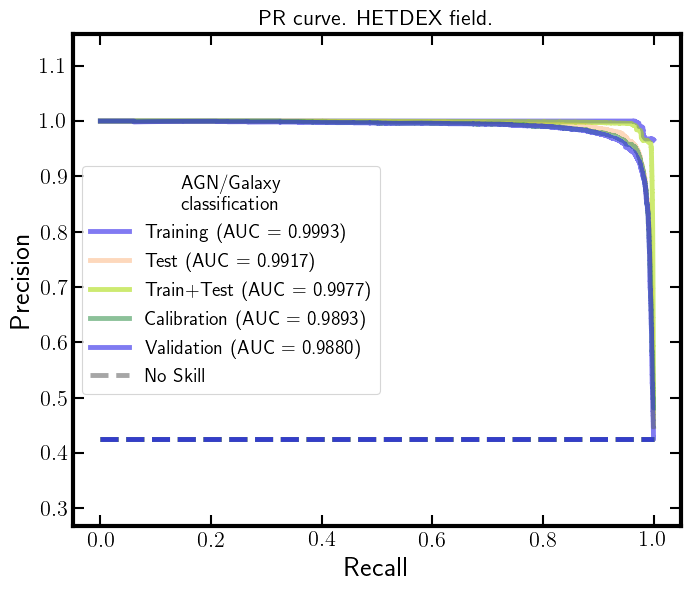

In [79]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train,      recall=recall_train)
viz_test        = PrecisionRecallDisplay(precision=prec_test,       recall=recall_test)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test, recall=recall_train_test)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib,      recall=recall_calib)
viz_val         = PrecisionRecallDisplay(precision=prec_validation, recall=recall_validation)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.6, label=f"Test        (AUC = {auc_pr_test:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc='best', fontsize=14, title='AGN/Galaxy\nclassification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [80]:
fscore_train      = (1 + gv.beta_F**2) * (prec_train      * recall_train)      / (prec_train * gv.beta_F**2      + recall_train)
fscore_test       = (1 + gv.beta_F**2) * (prec_test       * recall_test)       / (prec_test * gv.beta_F**2       + recall_test)
fscore_train_test = (1 + gv.beta_F**2) * (prec_train_test * recall_train_test) / (prec_train_test * gv.beta_F**2 + recall_train_test)
fscore_calib      = (1 + gv.beta_F**2) * (prec_calib      * recall_calib)      / (prec_calib * gv.beta_F**2      + recall_calib)
fscore_validation = (1 + gv.beta_F**2) * (prec_validation * recall_validation) / (prec_validation * gv.beta_F**2 + recall_validation)

In [81]:
opt_t_PR_train      = thresh_train[np.argmax(fscore_train)]
opt_t_PR_test       = thresh_test[np.argmax(fscore_test)]
opt_t_PR_train_test = thresh_train_test[np.argmax(fscore_train_test)]
opt_t_PR_calib      = thresh_calib[np.argmax(fscore_calib)]
opt_t_PR_validation = thresh_validation[np.argmax(fscore_validation)]

In [82]:
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation:.5f}')

Optimal threshold from Precision-Recall curve for training    = 0.49997
Optimal threshold from Precision-Recall curve for test        = 0.49998
Optimal threshold from Precision-Recall curve for train+test  = 0.50001
Optimal threshold from Precision-Recall curve for calibration = 0.49998
Optimal threshold from Precision-Recall curve for validation  = 0.49998


In [83]:
print(f'The selected threshold, from train+test sub-set is {opt_t_PR_train_test:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_train_test}')

The selected threshold, from train+test sub-set is 0.50001
And, in its complete extension, is 0.5000115951


---

In [84]:
AGN_pred_threshold = float(opt_t_PR_train_test) #  0.43475

In [85]:
train_prediction_clf      = pyc.predict_model(final_AGN_clf, data=train_df,       probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
test_prediction_clf       = pyc.predict_model(final_AGN_clf, data=test_df,        probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
train_test_prediction_clf = pyc.predict_model(final_AGN_clf, data=train_test_df,  probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
calib_prediction_clf      = pyc.predict_model(final_AGN_clf, data=calibration_df, probability_threshold=AGN_pred_threshold, raw_score=True, round=10)
validation_prediction_clf = pyc.predict_model(final_AGN_clf, data=validation_df,  probability_threshold=AGN_pred_threshold, raw_score=True, round=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9868138810,0.9994837732,0.9806455602,0.9882844145,0.9844501692,0.9730042722,0.9730263439


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9669438888,0.9928153445,0.9589413802,0.9632298137,0.9610808131,0.9323527908,0.9323598012


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9826292019,0.9980954093,0.9763789265,0.9826985312,0.9795285360,0.9644429564,0.9644580951


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9648384040,0.9912102795,0.9596834034,0.9577882004,0.9587348653,0.9281039564,0.9281053325


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9600791679,0.9900743319,0.9549861496,0.9514094224,0.9531944307,0.9183928822,0.9183977959


Create confusion matrices.

In [86]:
cm_mat_train      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label'])
cm_mat_test       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label'])
cm_mat_train_test = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label'])
cm_mat_calib      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label'])
cm_mat_val        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label'])

In [87]:
final_scores_df = gf.create_scores_df([cm_mat_train, cm_mat_test, cm_mat_train_test, cm_mat_calib, cm_mat_val],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [88]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(final_scores_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9841,0.9730,0.9883,0.9806
Test,0.9609,0.9324,0.9632,0.9589
Train+Test,0.9792,0.9645,0.9827,0.9764
Calibration,0.9588,0.9281,0.9578,0.9597
Validation,0.9534,0.9184,0.9514,0.9550


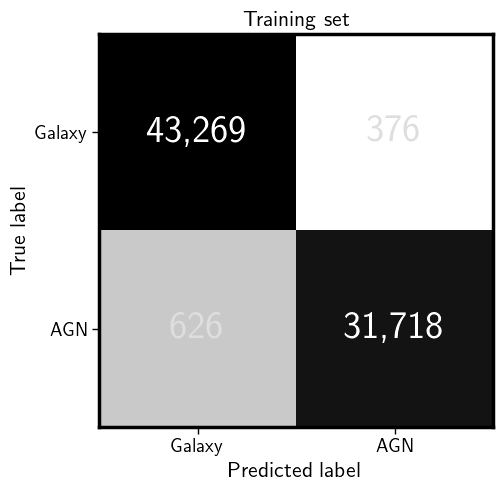

In [89]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

_ = gf.plot_conf_mat(cm_mat_train, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

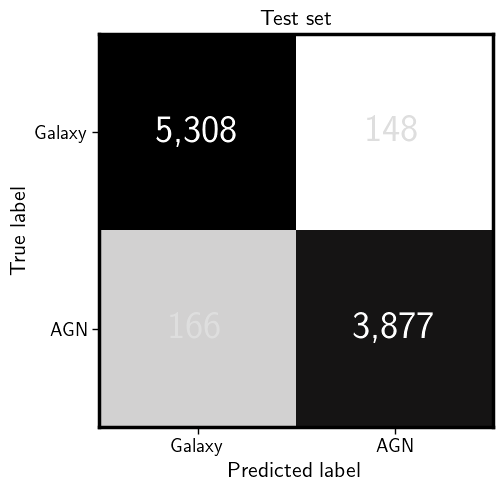

In [90]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

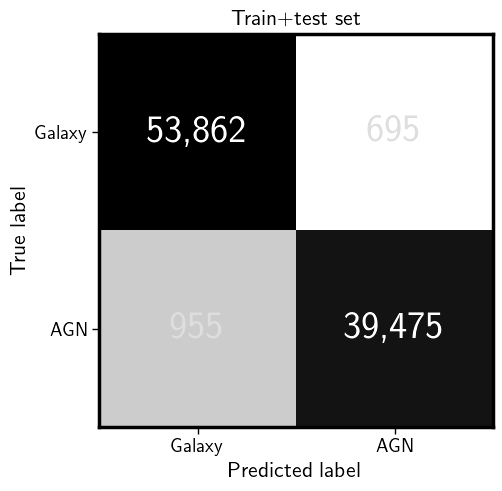

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

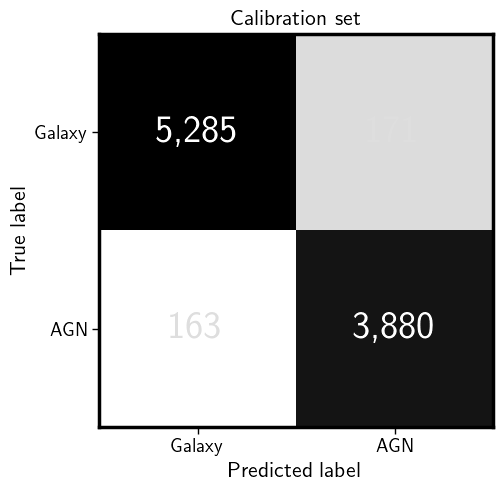

In [92]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib, title='Calibration set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

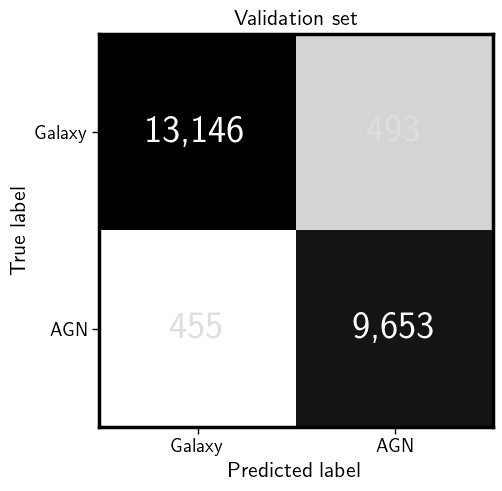

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

### Calibrate model and save it separately

In [94]:
print('Running data pre-processing for calibration (calibration set):\n')
extended_calibration_df = gf.preprocess_data(final_AGN_clf, calibration_df, base_models_names)
initial_cols            = extended_calibration_df.columns.drop(base_models_names)

Running data pre-processing for calibration (calibration set):



In [95]:
if save_model_flag:
    calibrated_final_AGN_clf = BetaCalibration(parameters='abm')
    calibrated_final_AGN_clf.fit(calib_prediction_clf.loc[:, 'Score_1'], calib_prediction_clf.loc[:, target_feat])
    dump(calibrated_final_AGN_clf, gv.models_path + gv.cal_AGN_gal_model)

In [96]:
if load_model_flag:
    calibrated_final_AGN_clf = load(gv.models_path + gv.cal_AGN_gal_model)

In [97]:
train_prediction_clf['Prob_AGN']      = calibrated_final_AGN_clf.predict(train_prediction_clf.loc[:, 'Score_1'])
test_prediction_clf['Prob_AGN']       = calibrated_final_AGN_clf.predict(test_prediction_clf.loc[:, 'Score_1'])
train_test_prediction_clf['Prob_AGN'] = calibrated_final_AGN_clf.predict(train_test_prediction_clf.loc[:, 'Score_1'])
calib_prediction_clf['Prob_AGN']      = calibrated_final_AGN_clf.predict(calib_prediction_clf.loc[:, 'Score_1'])
validation_prediction_clf['Prob_AGN'] = calibrated_final_AGN_clf.predict(validation_prediction_clf.loc[:, 'Score_1'])

In [98]:
train_prediction_clf['Label_cal_naive']      = np.array(train_prediction_clf.loc[:, 'Prob_AGN']      >= gv.naive_AGN_thresh).astype(int)
test_prediction_clf['Label_cal_naive']       = np.array(test_prediction_clf.loc[:, 'Prob_AGN']       >= gv.naive_AGN_thresh).astype(int)
train_test_prediction_clf['Label_cal_naive'] = np.array(train_test_prediction_clf.loc[:, 'Prob_AGN'] >= gv.naive_AGN_thresh).astype(int)
calib_prediction_clf['Label_cal_naive']      = np.array(calib_prediction_clf.loc[:, 'Prob_AGN']      >= gv.naive_AGN_thresh).astype(int)
validation_prediction_clf['Label_cal_naive'] = np.array(validation_prediction_clf.loc[:, 'Prob_AGN'] >= gv.naive_AGN_thresh).astype(int)

In [99]:
cm_mat_val_cal_naive        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal_naive'])
cm_mat_train_cal_naive      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal_naive'])
cm_mat_test_cal_naive       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal_naive'])
cm_mat_calib_cal_naive      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal_naive'])
cm_mat_train_test_cal_naive = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal_naive'])

In [100]:
scores_cal_naive_df = gf.create_scores_df([cm_mat_train_cal_naive, cm_mat_test_cal_naive,\
                                              cm_mat_train_test_cal_naive, cm_mat_calib_cal_naive, cm_mat_val_cal_naive],\
                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [101]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_naive_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9789,0.9628,0.9759,0.9814
Test,0.9611,0.9316,0.9577,0.9639
Train+Test,0.9751,0.9562,0.9720,0.9778
Calibration,0.9590,0.9278,0.9546,0.9627
Validation,0.9537,0.9181,0.9474,0.9589


##### Obtain optimal thresholds from train+test in calibrated model

##### Precision-Recall curve

In [102]:
prec_train_cal,      recall_train_cal,      thresh_train_cal      = precision_recall_curve(train_prediction_clf.loc[:, target_feat],\
                                                                               train_prediction_clf.loc[:, 'Prob_AGN'],      pos_label=1)
prec_test_cal,       recall_test_cal,       thresh_test_cal       = precision_recall_curve(test_prediction_clf.loc[:, target_feat],\
                                                                               test_prediction_clf.loc[:, 'Prob_AGN'],       pos_label=1)
prec_train_test_cal, recall_train_test_cal, thresh_train_test_cal = precision_recall_curve(train_test_prediction_clf.loc[:, target_feat],\
                                                                               train_test_prediction_clf.loc[:, 'Prob_AGN'], pos_label=1)
prec_calib_cal,      recall_calib_cal,      thresh_calib_cal      = precision_recall_curve(calib_prediction_clf.loc[:, target_feat],\
                                                                               calib_prediction_clf.loc[:, 'Prob_AGN'],      pos_label=1)
prec_validation_cal, recall_validation_cal, thresh_validation_cal = precision_recall_curve(validation_prediction_clf.loc[:, target_feat],\
                                                                               validation_prediction_clf.loc[:, 'Prob_AGN'], pos_label=1)

AUC for PR curve

In [103]:
auc_pr_train_cal      = auc(recall_train_cal,      prec_train_cal)
auc_pr_test_cal       = auc(recall_test_cal,       prec_test_cal)
auc_pr_train_test_cal = auc(recall_train_test_cal, prec_train_test_cal)
auc_pr_calib_cal      = auc(recall_calib_cal,      prec_calib_cal)
auc_pr_validation_cal = auc(recall_validation_cal, prec_validation_cal)

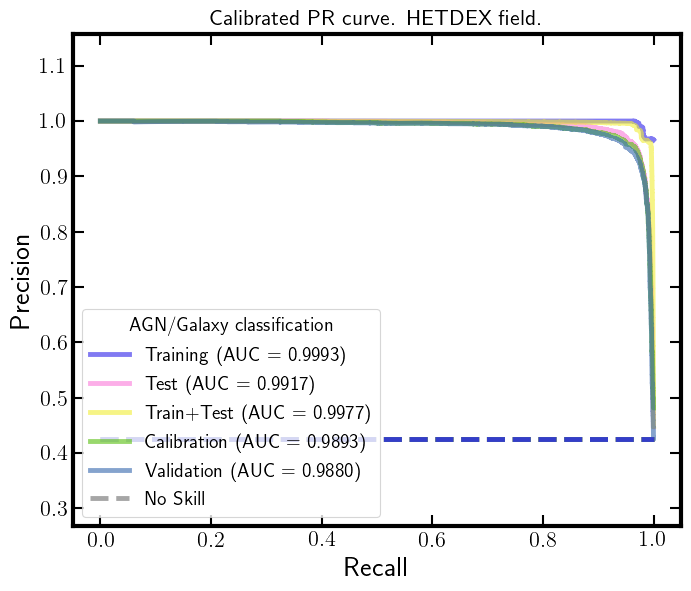

In [104]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train       = PrecisionRecallDisplay(precision=prec_train_cal,      recall=recall_train_cal)
viz_test        = PrecisionRecallDisplay(precision=prec_test_cal,       recall=recall_test_cal)
viz_train_test  = PrecisionRecallDisplay(precision=prec_train_test_cal, recall=recall_train_test_cal)
viz_calib       = PrecisionRecallDisplay(precision=prec_calib_cal,      recall=recall_calib_cal)
viz_val         = PrecisionRecallDisplay(precision=prec_validation_cal, recall=recall_validation_cal)
viz_train.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.6, label=f"Training    (AUC = {auc_pr_train_cal:.4f})")
viz_test.plot(ax=ax1,        lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.3), alpha=0.6, label=f"Test        (AUC = {auc_pr_test_cal:.4f})")
viz_train_test.plot(ax=ax1,  lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.5), alpha=0.6, label=f"Train+Test  (AUC = {auc_pr_train_test_cal:.4f})")
viz_calib.plot(ax=ax1,       lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.7), alpha=0.6, label=f"Calibration (AUC = {auc_pr_calib_cal:.4f})")
viz_val.plot(ax=ax1,         lw=3.5, c=cm.get_cmap('cet_CET_C2s')(0.9), alpha=0.6, label=f"Validation  (AUC = {auc_pr_validation_cal:.4f})")

no_skill_train      = np.sum(train_prediction_clf.loc[:, target_feat] == 1)      / len(train_prediction_clf.loc[:, target_feat])
no_skill_test       = np.sum(test_prediction_clf.loc[:, target_feat] == 1)       / len(test_prediction_clf.loc[:, target_feat])
no_skill_train_test = np.sum(train_test_prediction_clf.loc[:, target_feat] == 1) / len(train_test_prediction_clf.loc[:, target_feat])
no_skill_calib      = np.sum(calib_prediction_clf.loc[:, target_feat] == 1)      / len(calib_prediction_clf.loc[:, target_feat])
no_skill_val        = np.sum(validation_prediction_clf.loc[:, target_feat] == 1) / len(validation_prediction_clf.loc[:, target_feat])
ax1.plot([0, 1], [no_skill_train,      no_skill_train],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.0), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_test,       no_skill_test],       ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.4), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_train_test, no_skill_train_test], ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.6), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_calib,      no_skill_calib],      ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(0.8), alpha=0.8, lw=3.5)
ax1.plot([0, 1], [no_skill_val,        no_skill_val],        ls='--', marker=None, c=cm.get_cmap('cet_CET_C2s')(1.0), alpha=0.8, lw=3.5)
ax1.plot([1, 1], [1, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.5, label='No Skill', zorder=0)

# ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('Recall', fontsize=20)
ax1.set_ylabel('Precision', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=3.0)
plt.setp(ax1.spines.values(), linewidth=3.0)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=3, fontsize=14, title='AGN/Galaxy classification', title_fontsize=14)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('Calibrated PR curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'PR_cal_curve_classification_AGN_galaxy_04.pdf', bbox_inches='tight')
plt.show()

Find optimal threshold from PR curve

In [105]:
fscore_train_cal      = (1 + gv.beta_F**2) * (prec_train_cal      * recall_train_cal)      / (prec_train_cal * gv.beta_F**2      + recall_train_cal)
fscore_test_cal       = (1 + gv.beta_F**2) * (prec_test_cal       * recall_test_cal)       / (prec_test_cal * gv.beta_F**2       + recall_test_cal)
fscore_train_test_cal = (1 + gv.beta_F**2) * (prec_train_test_cal * recall_train_test_cal) / (prec_train_test_cal * gv.beta_F**2 + recall_train_test_cal)
fscore_calib_cal      = (1 + gv.beta_F**2) * (prec_calib_cal      * recall_calib_cal)      / (prec_calib_cal * gv.beta_F**2      + recall_calib_cal)
fscore_validation_cal = (1 + gv.beta_F**2) * (prec_validation_cal * recall_validation_cal) / (prec_validation_cal * gv.beta_F**2 + recall_validation_cal)

In [106]:
opt_t_PR_train_cal      = thresh_train_cal[np.argmax(fscore_train_cal)]
opt_t_PR_test_cal       = thresh_test_cal[np.argmax(fscore_test_cal)]
opt_t_PR_train_test_cal = thresh_train_test_cal[np.argmax(fscore_train_test_cal)]
opt_t_PR_calib_cal      = thresh_calib_cal[np.argmax(fscore_calib_cal)]
opt_t_PR_validation_cal = thresh_validation_cal[np.argmax(fscore_validation_cal)]

In [107]:
print('Otimal thresholds from calibrated Precision-Recal curves:')
print(f'Optimal threshold from Precision-Recall curve for training    = {opt_t_PR_train_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for test        = {opt_t_PR_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for train+test  = {opt_t_PR_train_test_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for calibration = {opt_t_PR_calib_cal:.5f}')
print(f'Optimal threshold from Precision-Recall curve for validation  = {opt_t_PR_validation_cal:.5f}')

Otimal thresholds from calibrated Precision-Recal curves:
Optimal threshold from Precision-Recall curve for training    = 0.24088
Optimal threshold from Precision-Recall curve for test        = 0.36469
Optimal threshold from Precision-Recall curve for train+test  = 0.61812
Optimal threshold from Precision-Recall curve for calibration = 0.34895
Optimal threshold from Precision-Recall curve for validation  = 0.32472


In [108]:
print(f'The selected threshold, from calibration sub-set is {opt_t_PR_calib_cal:.5f}')
print(f'And, in its complete extension, is {opt_t_PR_calib_cal}')

The selected threshold, from calibration sub-set is 0.34895
And, in its complete extension, is 0.34895396724527294


In [109]:
train_prediction_clf['Label_cal']      = np.array(train_prediction_clf.loc[:, 'Prob_AGN']      >= opt_t_PR_calib_cal).astype(int)
test_prediction_clf['Label_cal']       = np.array(test_prediction_clf.loc[:, 'Prob_AGN']       >= opt_t_PR_calib_cal).astype(int)
train_test_prediction_clf['Label_cal'] = np.array(train_test_prediction_clf.loc[:, 'Prob_AGN'] >= opt_t_PR_calib_cal).astype(int)
calib_prediction_clf['Label_cal']      = np.array(calib_prediction_clf.loc[:, 'Prob_AGN']      >= opt_t_PR_calib_cal).astype(int)
validation_prediction_clf['Label_cal'] = np.array(validation_prediction_clf.loc[:, 'Prob_AGN'] >= opt_t_PR_calib_cal).astype(int)

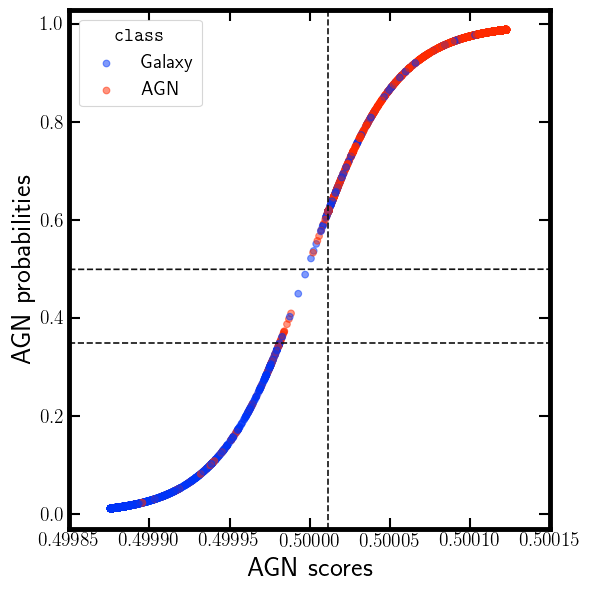

In [110]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

set_to_plot     = calib_prediction_clf

ax1.scatter(set_to_plot.loc[:, 'Score_1'], set_to_plot.loc[:, 'Prob_AGN'], marker='o',\
            alpha=0.5, c=set_to_plot.loc[:, target_feat],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat]))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=opt_t_PR_calib_cal, color='k', ls='dashed')
ax1.axvline(x=opt_t_PR_train_test, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Galaxy',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(set_to_plot.loc[:, target_feat])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
# ax1.set_xlim(left=-0.03, right=1.03)
# ax1.set_xlim(left=0.38, right=0.61)
ax1.set_xlim(left=0.49985, right=0.50015)
ax1.set_ylim(bottom=-0.03, top=1.03)
fig.tight_layout()
plt.show()

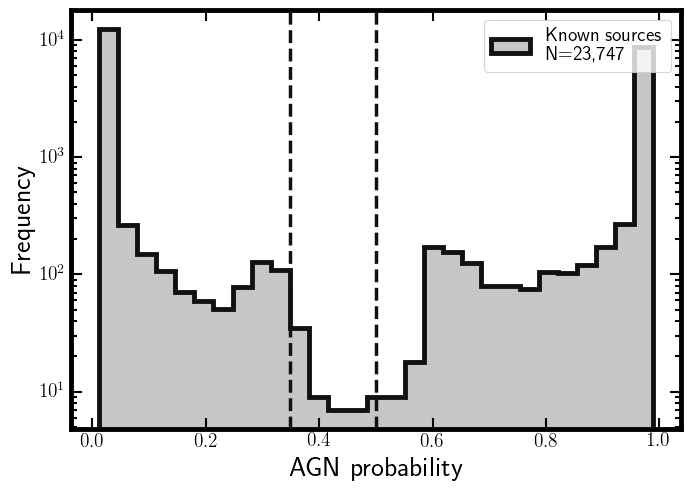

In [111]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

set_to_plot     = validation_prediction_clf

min_score  = np.nanmin(set_to_plot.loc[:, 'Prob_AGN'])
max_score  = np.nanmax(set_to_plot.loc[:, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = len(set_to_plot.loc[:, 'Prob_AGN'])

ax1.hist(set_to_plot.loc[:, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'Known sources\nN={sample_size:,}')

ax1.axvline(x=0.5, ls='--', c='k', lw=2.5)
ax1.axvline(x=opt_t_PR_calib_cal, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_predicted_AGN_cal_probs_validation.pdf', bbox_inches='tight')
plt.show()

#### Calibration curve

In [112]:
fract_positiv_train_test_cal, mean_pred_val_train_test_cal =\
                        calibration_curve(train_test_prediction_clf.loc[:, target_feat],\
                                          train_test_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_calib_cal, mean_pred_val_calib_cal =\
                        calibration_curve(calib_prediction_clf.loc[:, target_feat],\
                                          calib_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

fract_positiv_val_cal, mean_pred_val_val_cal =\
                        calibration_curve(validation_prediction_clf.loc[:, target_feat],\
                                          validation_prediction_clf.loc[:, 'Prob_AGN'],\
                                          n_bins=30, normalize=False, strategy='quantile')  # calibration_curve(y_test, prob_pos, n_bins=10)

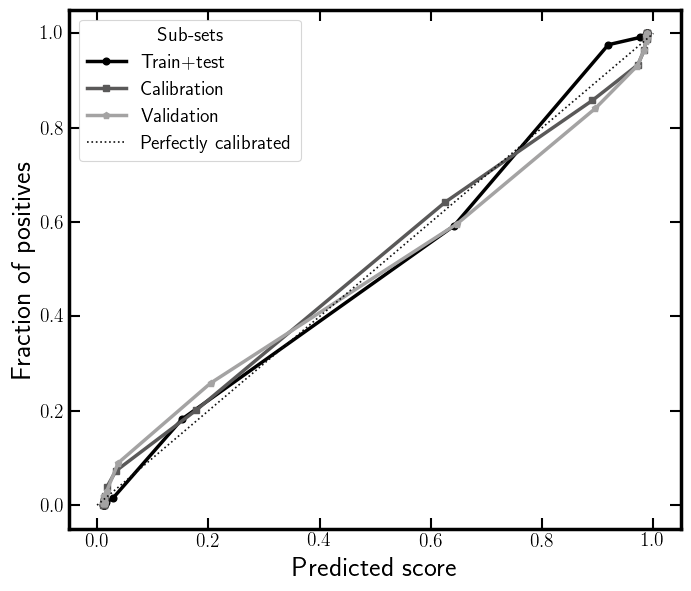

In [113]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_train_test_cal, fract_positiv_train_test_cal, ls='-',\
         marker='o', c=plt.get_cmap(gv.cmap_conf_matr)(1.0), lw=2.5, label='Train+test')
ax1.plot(mean_pred_val_calib_cal, fract_positiv_calib_cal, ls='-', marker='s',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.6), lw=2.5, label='Calibration')
ax1.plot(mean_pred_val_val_cal, fract_positiv_val_cal, ls='-', marker='p',\
         c=plt.get_cmap(gv.cmap_conf_matr)(0.3), lw=2.5, label='Validation')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label='Perfectly calibrated')
ax1.set_xlabel('Predicted score', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.legend(loc='best', fontsize=14, title='Sub-sets', title_fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'calib_curves_post_calib_AGN_galaxy.pdf', bbox_inches='tight')
plt.show()

### Check if calibration was useful

Brier score is used for this. And, in particular, Brier Skill Score (BSS).  
Its values can be in the range $[0, 1]$

If BSS $\ll 0$, calibration was not succesful. If BSS $\approx 0$, it performs as the previous model.  
If BSS $\gg 0$, calibration is useful and performs better than original model.

In [114]:
BS_ref = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label'],     pos_label=1)
BS     = brier_score_loss(validation_prediction_clf.loc[:, target_feat], validation_prediction_clf.loc[:, 'Label_cal'], pos_label=1)
BSS    = 1 - (BS/BS_ref)

In [115]:
print(f'Brier Skill Score is {BSS:.3f} using the validation set.')

Brier Skill Score is -0.002 using the validation set.


Create confusion matrices.

In [116]:
cm_mat_train_cal      = gf.conf_mat_func(train_prediction_clf[target_feat],      train_prediction_clf['Label_cal'])
cm_mat_test_cal       = gf.conf_mat_func(test_prediction_clf[target_feat],       test_prediction_clf['Label_cal'])
cm_mat_train_test_cal = gf.conf_mat_func(train_test_prediction_clf[target_feat], train_test_prediction_clf['Label_cal'])
cm_mat_calib_cal      = gf.conf_mat_func(calib_prediction_clf[target_feat],      calib_prediction_clf['Label_cal'])
cm_mat_val_cal        = gf.conf_mat_func(validation_prediction_clf[target_feat], validation_prediction_clf['Label_cal'])

In [117]:
scores_cal_df = gf.create_scores_df([cm_mat_train_cal, cm_mat_test_cal, cm_mat_train_test_cal, cm_mat_calib_cal, cm_mat_val_cal],\
                                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [118]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9814,0.9655,0.9678,0.9929
Test,0.9616,0.9319,0.9551,0.9671
Train+Test,0.9773,0.9585,0.9651,0.9876
Calibration,0.9602,0.9293,0.9534,0.9659
Validation,0.9542,0.9185,0.9449,0.9621


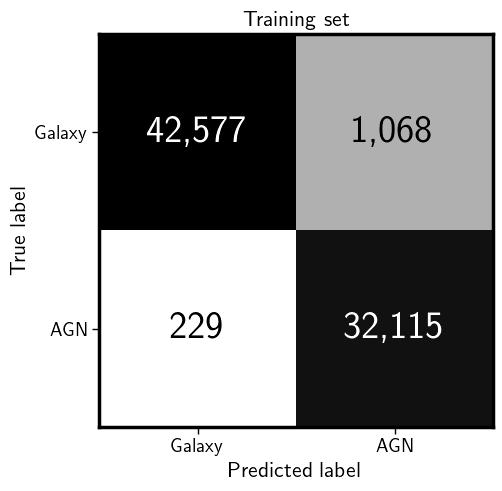

In [180]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_cal, title='Training set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

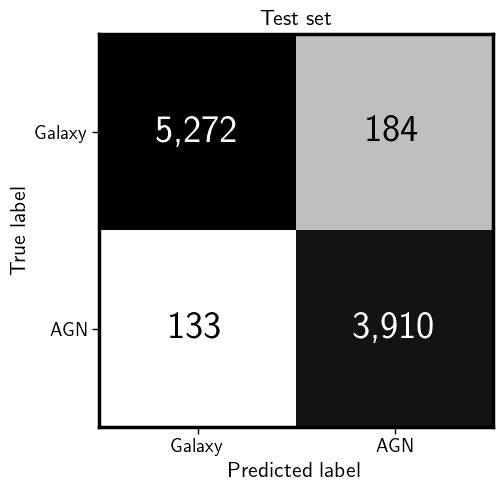

In [179]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test_cal, title='Test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

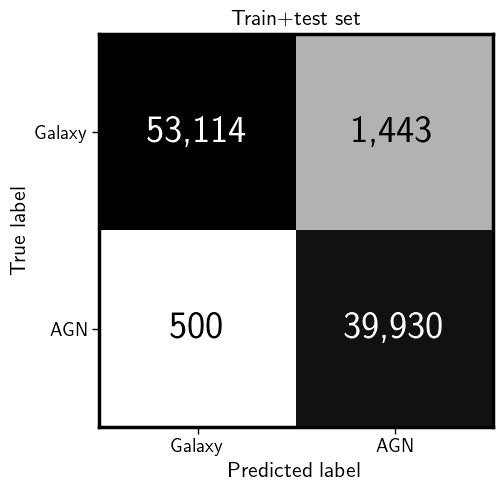

In [178]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test_cal, title='Train+test set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

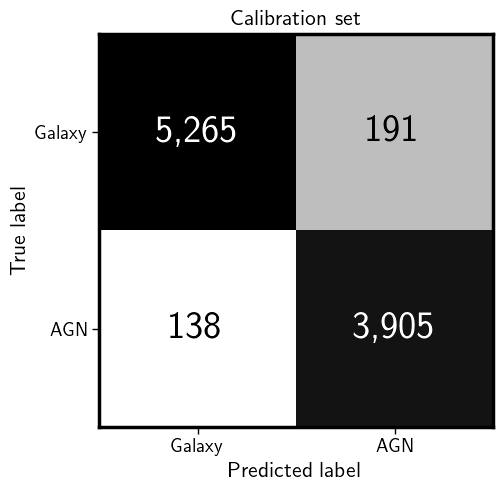

In [177]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib_cal, title='Calibration set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

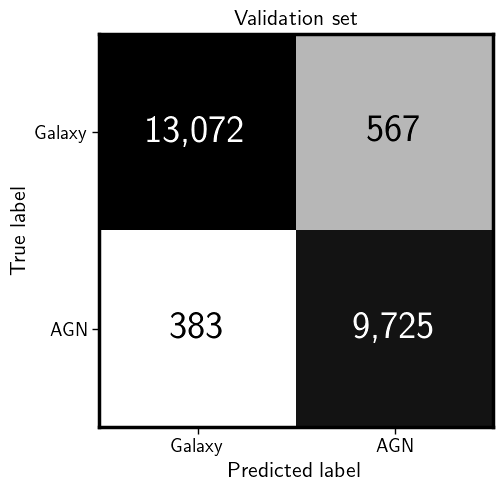

In [176]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val_cal, title='Validation set', axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

#### Obtaining uncertainty values from calibrated model

In [124]:
# final_estimator = final_AGN_clf.named_steps['trained_model'].final_estimator_

In [126]:
# from sklearn.model_selection import cross_val_score

In [127]:
# from sklearn.model_selection import cross_val_predict

In [131]:
# from sklearn.metrics import fbeta_score, make_scorer

In [132]:
# fbeta_scorer = make_scorer(fbeta_score, beta=1.1)

In [133]:
CV_object = StratifiedKFold(n_splits=10, random_state=gv.seed, shuffle=True)

In [134]:
cv_scores = {}

In [135]:
subsets_arr = [train_prediction_clf, test_prediction_clf, 
               train_test_prediction_clf, calib_prediction_clf, 
               validation_prediction_clf]

In [136]:
subset_names = ['train', 'test', 'train + test', 'calibration', 'validation']

In [139]:
for count, (subset, subset_name) in enumerate(zip(subsets_arr, subset_names)):
    tmp_f_betas = []
    tmp_mccs    = []
    tmp_precs   = []
    tmp_recalls = []
    for _, fold_index in iter(CV_object.split(subset.loc[:, 'Score_1'], subset.loc[:, target_feat])):
        tmp_f_beta = pyc.get_metrics().loc['f_beta', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_mcc    = pyc.get_metrics().loc['mcc', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_prec   = pyc.get_metrics().loc['precision', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_recall = pyc.get_metrics().loc['recall', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_f_betas.append(tmp_f_beta)
        tmp_mccs.append(tmp_mcc)
        tmp_precs.append(tmp_prec)
        tmp_recalls.append(tmp_recall)
    cv_scores[subset_name] = {'f_beta': tmp_f_betas, 'mcc': tmp_mccs, 'precision': tmp_precs, 'recall': tmp_recalls}

In [140]:
cv_scores_mean = {}
cv_scores_std  = {}

In [141]:
for sub_set in cv_scores:
    cv_scores_mean[sub_set] = {}
    cv_scores_std[sub_set] = {}
    for score in cv_scores[sub_set]:
        cv_scores_mean[sub_set][score] = np.nanmean(cv_scores[sub_set][score])
        cv_scores_std[sub_set][score]  = np.nanstd(cv_scores[sub_set][score])
        

In [142]:
for sub_set in cv_scores:
    print('-' * 20 + sub_set + '-' * 20)
    print(f'F_beta score for {sub_set} set: {cv_scores_mean[sub_set]["f_beta"]:.4f} ± {cv_scores_std[sub_set]["f_beta"]:.4f}')
    print(f'MCC for {sub_set} set:          {cv_scores_mean[sub_set]["mcc"]:.4f} ± {cv_scores_std[sub_set]["mcc"]:.4f}')
    print(f'Precision for {sub_set} set:    {cv_scores_mean[sub_set]["mcc"]:.4f} ± {cv_scores_std[sub_set]["precision"]:.4f}')
    print(f'Recall score for {sub_set} set: {cv_scores_mean[sub_set]["recall"]:.4f} ± {cv_scores_std[sub_set]["recall"]:.4f}')
    print('-' * 55)

--------------------train--------------------
F_beta score for train set: 0.9790 ± 0.0019
MCC for train set:          0.9655 ± 0.0031
Precision for train set:    0.9655 ± 0.0008
Recall score for train set: 0.9678 ± 0.0029
-------------------------------------------------------
--------------------test--------------------
F_beta score for test set: 0.9605 ± 0.0063
MCC for test set:          0.9320 ± 0.0111
Precision for test set:    0.9320 ± 0.0098
Recall score for test set: 0.9551 ± 0.0076
-------------------------------------------------------
--------------------train + test--------------------
F_beta score for train + test set: 0.9752 ± 0.0011
MCC for train + test set:          0.9585 ± 0.0019
Precision for train + test set:    0.9585 ± 0.0020
Recall score for train + test set: 0.9651 ± 0.0022
-------------------------------------------------------
--------------------calibration--------------------
F_beta score for calibration set: 0.9590 ± 0.0056
MCC for calibration set:          

### Obtain scores with target being SFGs (`class == 0`)

In [152]:
subsets_arr_gal = [train_prediction_clf.copy(), test_prediction_clf.copy(),
                    train_test_prediction_clf.copy(), calib_prediction_clf.copy(),
                    validation_prediction_clf.copy()]

In [153]:
cv_scores_gal = {}

In [154]:
for subset in subsets_arr_gal:
    subset.loc[:, target_feat]       = 1 - subset.loc[:, target_feat]
    subset.loc[:, 'Label_cal']       = 1 - subset.loc[:, 'Label_cal']
    subset.loc[:, 'Label_cal_naive'] = 1 - subset.loc[:, 'Label_cal_naive']

In [155]:
for count, (subset, subset_name) in enumerate(zip(subsets_arr_gal, subset_names)):
    tmp_f_betas = []
    tmp_mccs    = []
    tmp_precs   = []
    tmp_recalls = []
    for _, fold_index in iter(CV_object.split(subset.loc[:, 'Score_1'], subset.loc[:, target_feat])):
        tmp_f_beta = pyc.get_metrics().loc['f_beta', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_mcc    = pyc.get_metrics().loc['mcc', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_prec   = pyc.get_metrics().loc['precision', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_recall = pyc.get_metrics().loc['recall', 'Score Function'](subset.iloc[fold_index].loc[:, 'Label_cal'], subset.iloc[fold_index].loc[:, target_feat])
        tmp_f_betas.append(tmp_f_beta)
        tmp_mccs.append(tmp_mcc)
        tmp_precs.append(tmp_prec)
        tmp_recalls.append(tmp_recall)
    cv_scores_gal[subset_name] = {'f_beta': tmp_f_betas, 'mcc': tmp_mccs, 'precision': tmp_precs, 'recall': tmp_recalls}

In [156]:
cv_scores_mean_gal = {}
cv_scores_std_gal  = {}

In [157]:
for sub_set in cv_scores_gal:
    cv_scores_mean_gal[sub_set] = {}
    cv_scores_std_gal[sub_set] = {}
    for score in cv_scores_gal[sub_set]:
        cv_scores_mean_gal[sub_set][score] = np.nanmean(cv_scores_gal[sub_set][score])
        cv_scores_std_gal[sub_set][score]  = np.nanstd(cv_scores_gal[sub_set][score])
        

In [158]:
print('-' * 20 + 'Scores for Galaxies' + '-' * 20)
for sub_set in cv_scores_gal:
    print('-' * 20 + sub_set + '-' * 20)
    print(f'F_beta score for {sub_set} set: {cv_scores_mean_gal[sub_set]["f_beta"]:.4f} ± {cv_scores_std_gal[sub_set]["f_beta"]:.4f}')
    print(f'MCC for {sub_set} set:          {cv_scores_mean_gal[sub_set]["mcc"]:.4f} ± {cv_scores_std_gal[sub_set]["mcc"]:.4f}')
    print(f'Precision for {sub_set} set:    {cv_scores_mean_gal[sub_set]["mcc"]:.4f} ± {cv_scores_std_gal[sub_set]["precision"]:.4f}')
    print(f'Recall score for {sub_set} set: {cv_scores_mean_gal[sub_set]["recall"]:.4f} ± {cv_scores_std_gal[sub_set]["recall"]:.4f}')
    print('-' * 55)

--------------------Scores for Galaxies--------------------
--------------------train--------------------
F_beta score for train set: 0.9859 ± 0.0013
MCC for train set:          0.9655 ± 0.0031
Precision for train set:    0.9655 ± 0.0023
Recall score for train set: 0.9946 ± 0.0006
-------------------------------------------------------
--------------------test--------------------
F_beta score for test set: 0.9713 ± 0.0048
MCC for test set:          0.9320 ± 0.0111
Precision for test set:    0.9320 ± 0.0059
Recall score for test set: 0.9754 ± 0.0071
-------------------------------------------------------
--------------------train + test--------------------
F_beta score for train + test set: 0.9829 ± 0.0008
MCC for train + test set:          0.9585 ± 0.0019
Precision for train + test set:    0.9585 ± 0.0017
Recall score for train + test set: 0.9907 ± 0.0015
-------------------------------------------------------
--------------------calibration--------------------
F_beta score for calibra

Create confusion matrices.

In [159]:
cm_mat_train_cal_gal      = gf.conf_mat_func(subsets_arr_gal[0][target_feat], subsets_arr_gal[0]['Label_cal'])
cm_mat_test_cal_gal       = gf.conf_mat_func(subsets_arr_gal[1][target_feat], subsets_arr_gal[1]['Label_cal'])
cm_mat_train_test_cal_gal = gf.conf_mat_func(subsets_arr_gal[2][target_feat], subsets_arr_gal[2]['Label_cal'])
cm_mat_calib_cal_gal      = gf.conf_mat_func(subsets_arr_gal[3][target_feat], subsets_arr_gal[3]['Label_cal'])
cm_mat_val_cal_gal        = gf.conf_mat_func(subsets_arr_gal[4][target_feat], subsets_arr_gal[4]['Label_cal'])

In [160]:
scores_cal_gal_df = gf.create_scores_df([cm_mat_train_cal_gal, cm_mat_test_cal_gal,
                                         cm_mat_train_test_cal_gal, cm_mat_calib_cal_gal, cm_mat_val_cal_gal],\
                                       ['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                                       ['F-\u03B2', 'MCC', 'Precision', 'Recall', 'ACC'])

In [161]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(scores_cal_gal_df.drop(columns=['ACC']))

,F-β,MCC,Precision,Recall
Train,0.9841,0.9655,0.9947,0.9755
Test,0.9704,0.9319,0.9754,0.9663
Train+Test,0.9812,0.9585,0.9907,0.9736
Calibration,0.9693,0.9293,0.9745,0.9650
Validation,0.9643,0.9185,0.9715,0.9584


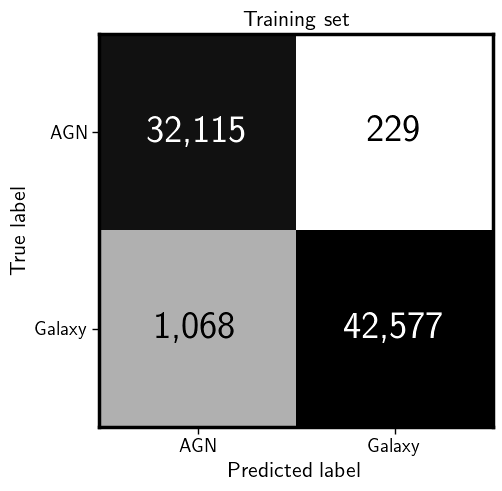

In [175]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_cal_gal, title='Training set', axin=ax1, display_labels=['AGN', 'Galaxy'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

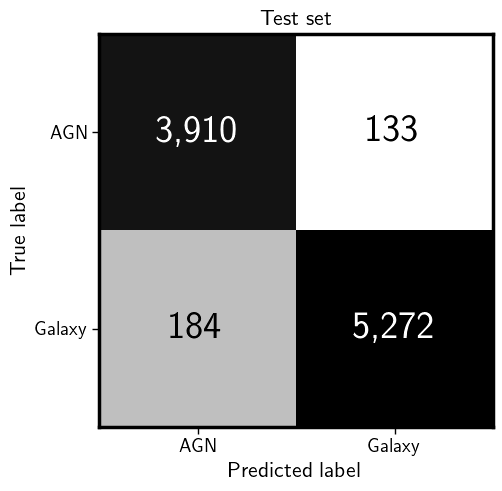

In [171]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_test_cal_gal, title='Test set', axin=ax1, display_labels=['AGN', 'Galaxy'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

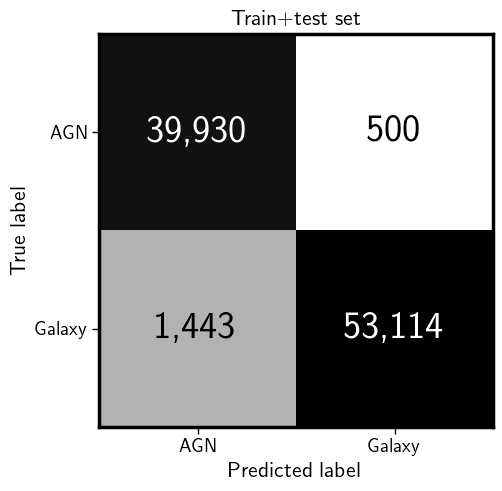

In [172]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_train_test_cal_gal, title='Train+test set', axin=ax1, display_labels=['AGN', 'Galaxy'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_train_test_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

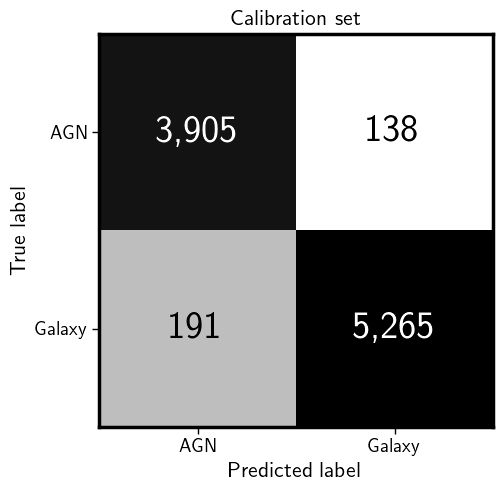

In [173]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_calib_cal_gal, title='Calibration set', axin=ax1, display_labels=['AGN', 'Galaxy'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_calibration_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()

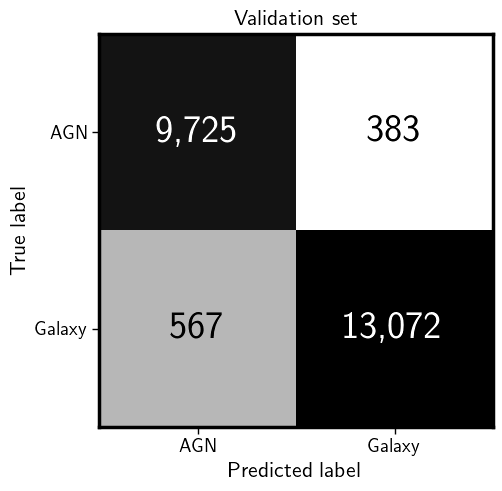

In [174]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)

ax1 = gf.plot_conf_mat(cm_mat_val_cal_gal, title='Validation set', axin=ax1, display_labels=['AGN', 'Galaxy'], log_stretch=False)
for count in [1, 2]:
    ax1.texts[count].set_color('black')
if save_plot_flag:
    plt.savefig(gv.plots_path + 'conf_matrix_validation_classification_AGN_galaxy_cal.pdf', bbox_inches='tight')
plt.show()